<a href="https://colab.research.google.com/github/ngcaonghi/compneuro-explore/blob/master/steinmetz_dataset/explore_manifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount data from Google Drive (if this notebook is run on Colab) { form-width: "25%" }
from google.colab import drive
drive.mount(r'/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
#@title Import matplotlib and set defaults { form-width: "25%" }
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
%config InlineBackend.figure_format = 'retina'

In [ ]:
#@title Import packages { form-width: "25%" }
!pip install numba umap-learn 

import collections
import copy
import numpy as np
import os, requests
import ipywidgets as widgets
# from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import umap

# import torch
# from torch import nn, optim
# device = torch.device('cuda')

# %load_ext autoreload
# %autoreload 2

In [ ]:
#@title Data retrieval { form-width: "25%" }

# Code in this cell by Nick Steinmetz and Neuromatch Academy team.
# Link: https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
#@title Data loading { form-width: "25%" }

#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

dat = alldat[11]

In [ ]:
#@title Data overview { form-width: "25%" }
@widgets.interact(key=widgets.Dropdown(options=list(dat.keys()), description="Key"))
def overview_field(key):
  d = dat[key]
  if isinstance(d, np.ndarray):
    print(d.shape)
    print("head sample:", d[:1])
    try:
      print("max:", np.max(d))
      print("min:", np.min(d))
      print("mean:", np.mean(d))
      print("median:", np.median(d))
      print("std", np.std(d))
      np.seterr(divide='ignore', invalid='ignore')
    except TypeError:
      pass
  elif isinstance(d, list):
      print(len(d))
      print("head sample:", d[:1])
  else:
      print(d)


interactive(children=(Dropdown(description='Key', options=('spks', 'wheel', 'pupil', 'response', 'response_tim…

In [ ]:
popul_by_area = collections.OrderedDict()
for i, area in enumerate(dat['brain_area']):
  if area not in popul_by_area:
    popul_by_area[area] = []
  popul_by_area[area].append(i)

for area in popul_by_area:
  print(area, len(popul_by_area[area]))

VISp 66
DG 65
SUB 105
LGd 11
PL 56
root 100
MOs 6
ACA 16
CA1 50
VISam 79
MD 126
LH 18


# 1. Spike trains

In [ ]:
#@title Helper Functions { form-width: "25%" }

BIN_SIZE = dat['bin_size']

def order_data(data=dat['spks']):
  a_list = list(popul_by_area.keys())
  spks_ordered = data[popul_by_area[a_list[0]]]
  for a in a_list[1:]:
    spks_ordered = np.vstack((spks_ordered, data[popul_by_area[a]]))
  return spks_ordered

def t_series(trial, data=dat['spks'], area='All', 
             bins=np.arange(dat['spks'].shape[2])):
  '''
  Creates time series of an area of interest over a number of trials.
  Arguments:
    - trial (int, list, numpy 1D array): trial(s) of interest
    - area (str): the name of the area of interest. Default is "All".
    - bins (list, numpy 1D array): time bins of interest. Default is all bins.
  Return:
    A tuple consisting of:
    - A numpy array in the shape of (number of neurons in the area, 
    number of trials (if more than 1), time bins)
    - The area and trial(s) of interest, just for passing to plotting functions
    - A tuple of start and stop time marks
  '''
  if area == 'All':
    neurons = order_data()
  else:
    neurons = data[popul_by_area[area]]

  if not isinstance(trial, int):
    neurons = neurons[:, trial, :][:, :, bins]
  else:
    neurons = neurons[:, trial][:, bins]
  
  t_marks = (bins[0] * BIN_SIZE, bins[-1] * BIN_SIZE)
  return neurons, area, trial, t_marks

def raster_plot(t_series_tuple):
  '''
  Creates raster plots of neuronal spikes.

  Arguments:
    - t_series_tuple (tuple): tuple returned by the t_series function, including
    a numpy array representing the time series of spikes, the area of interest,
    the trial(s) of interest, and time marks.
  
  Return:
    Pyplot raster plots.
  '''
  # unpack tuple
  t_series = t_series_tuple[0]
  area = t_series_tuple[1]
  trials = t_series_tuple[2]
  start, stop = t_series_tuple[3]

  # reshape t_series for single-trial time series
  if len(t_series.shape) != 3:
    n, bins = t_series.shape
    t_series_ = t_series.reshape(n, 1, bins)
  else:
    t_series_ = t_series
  
  # variables
  n_range = np.arange(t_series_.shape[0])
  num_n = len(n_range)
  trials_ = np.array([trials]) if isinstance(trials, int) else trials
  t_range = np.arange(t_series_.shape[2])

  ms = 2
  if area == 'All':
    plt.figure(figsize=[25, 12])
    ms = 1
  else:
    plt.figure(figsize=[25, num_n // 12 + 2])

  # start plotting
  for tridx, tr in enumerate(trials_):
    ax = plt.subplot(t_series_.shape[1] // 2 + 1, 2, tridx+1)
    trial = t_series_[:, tridx, :].reshape(num_n, len(t_range))

    for n in n_range:
      spikes = t_range[trial[n, :] >= 1] * BIN_SIZE 
      ax.plot(spikes, n * np.ones(len(spikes)), 'k|', ms=ms, markeredgewidth=2)

    ax.vlines(dat['stim_onset'] - start - 1e-3, ymin=0, ymax=num_n, 
              linestyles='dashed', color='b', alpha=0.3, label='onset')
    
    if isinstance(trials, int):
      tr = trials
    ax.set(xlabel='time', ylabel='neuron', title='trial {}'.format(tr))
    ax.vlines(dat['gocue'][tr] - start, ymin=0, ymax=num_n, linestyles='dashed', 
              color='orange', alpha=0.3, label='go cue')
    ax.vlines(dat['response_time'][tr] - start, ymin=0, ymax=num_n, 
              linestyles='solid', color='r', alpha=0.3, label='response time')

  # choose appropriate ticks and labels for y axis
  if area == 'All':
    a_list = list(popul_by_area.keys())
    yticks = [len(popul_by_area[a_list[0]])-0.5]
    y_idx = len(popul_by_area[a_list[0]])-0.5
    for a in a_list[1:]:
      y_idx += len(popul_by_area[a])
      yticks.append(y_idx)
    plt.hlines(yticks, xmin=0, xmax=stop-start, linestyles='solid', 
               linewidth=0.5, color='k', alpha=0.5)
    plt.yticks(yticks, fontsize='small', labels=a_list)
  else: 
    plt.yticks([num_n-1], label=num_n)

  plt.xticks(np.linspace(0, stop-start, 6), 
             labels=np.around(np.linspace(start, stop, 6), decimals=1))
  plt.legend(loc='best', fontsize='small')
  plt.suptitle(area)
  plt.show()

def is_correct(trials):
  '''
  Checks if the mouse makes the correct decision on each trial.

  Arguments:
    - trial (int, list, np.ndarray): trial(s) of interest

  Return:
    A numpy array of boolean values indicating decision correctness.
  '''
  if isinstance(trials, int):
    trials = [trials]
  stim_left = dat['contrast_left'][trials]
  stim_right = dat['contrast_right'][trials]
  truth = np.sign(stim_left - stim_right)
  resp = np.sign(dat['response'][trials])
  return np.array([t==r for t in truth for r in resp])

def stim_to_resp(trial):
  '''
  Extracts time bins from stimulus onset to reponse time.

  Argument:
    - trial (int): trial of interest
  
  Return:
    A numpy array of time bins.
  '''
  return np.arange(dat['stim_onset'] / BIN_SIZE, 
                   dat['response_time'][trial] / BIN_SIZE,
                   dtype = int)

In [ ]:
# creates an array of decision correctness of all trials

correctness = np.zeros(len(dat['response']), dtype=bool)
for i in range(len(correctness)):
  correctness[i] = is_correct(i)

correctness[:5]

array([ True, False,  True,  True,  True])

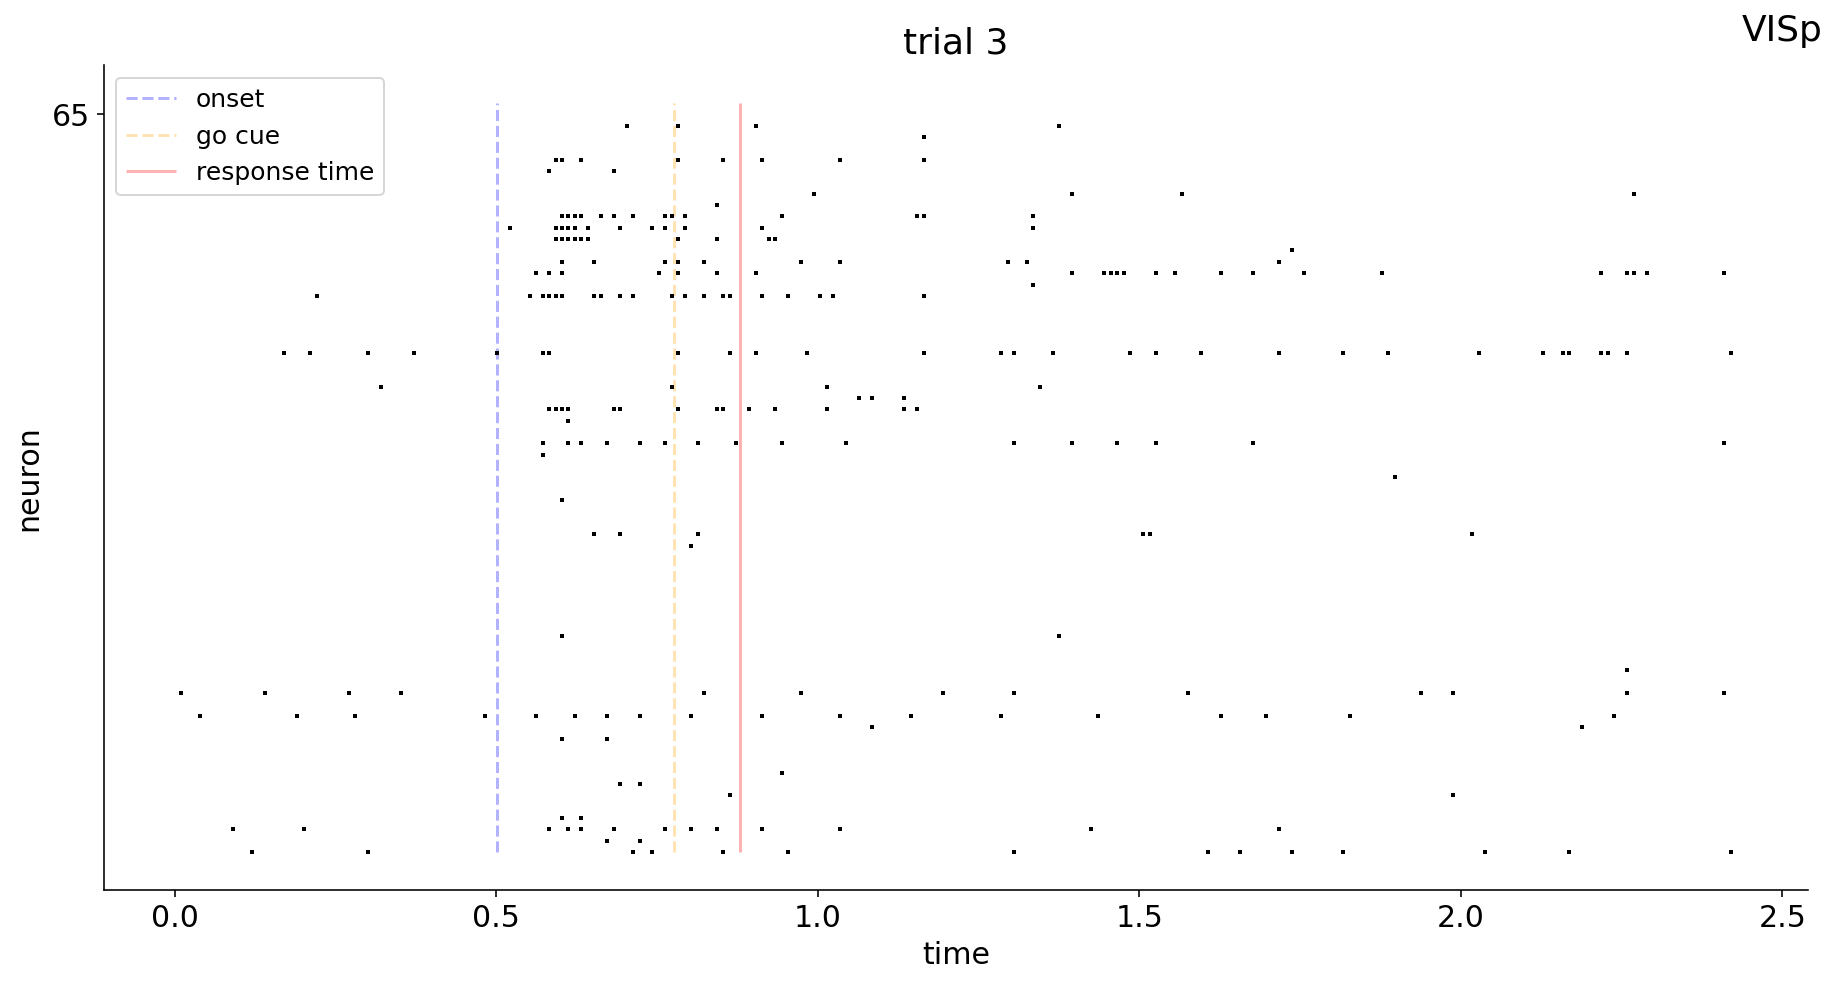

In [ ]:
raster_plot(t_series(3, area='VISp'))

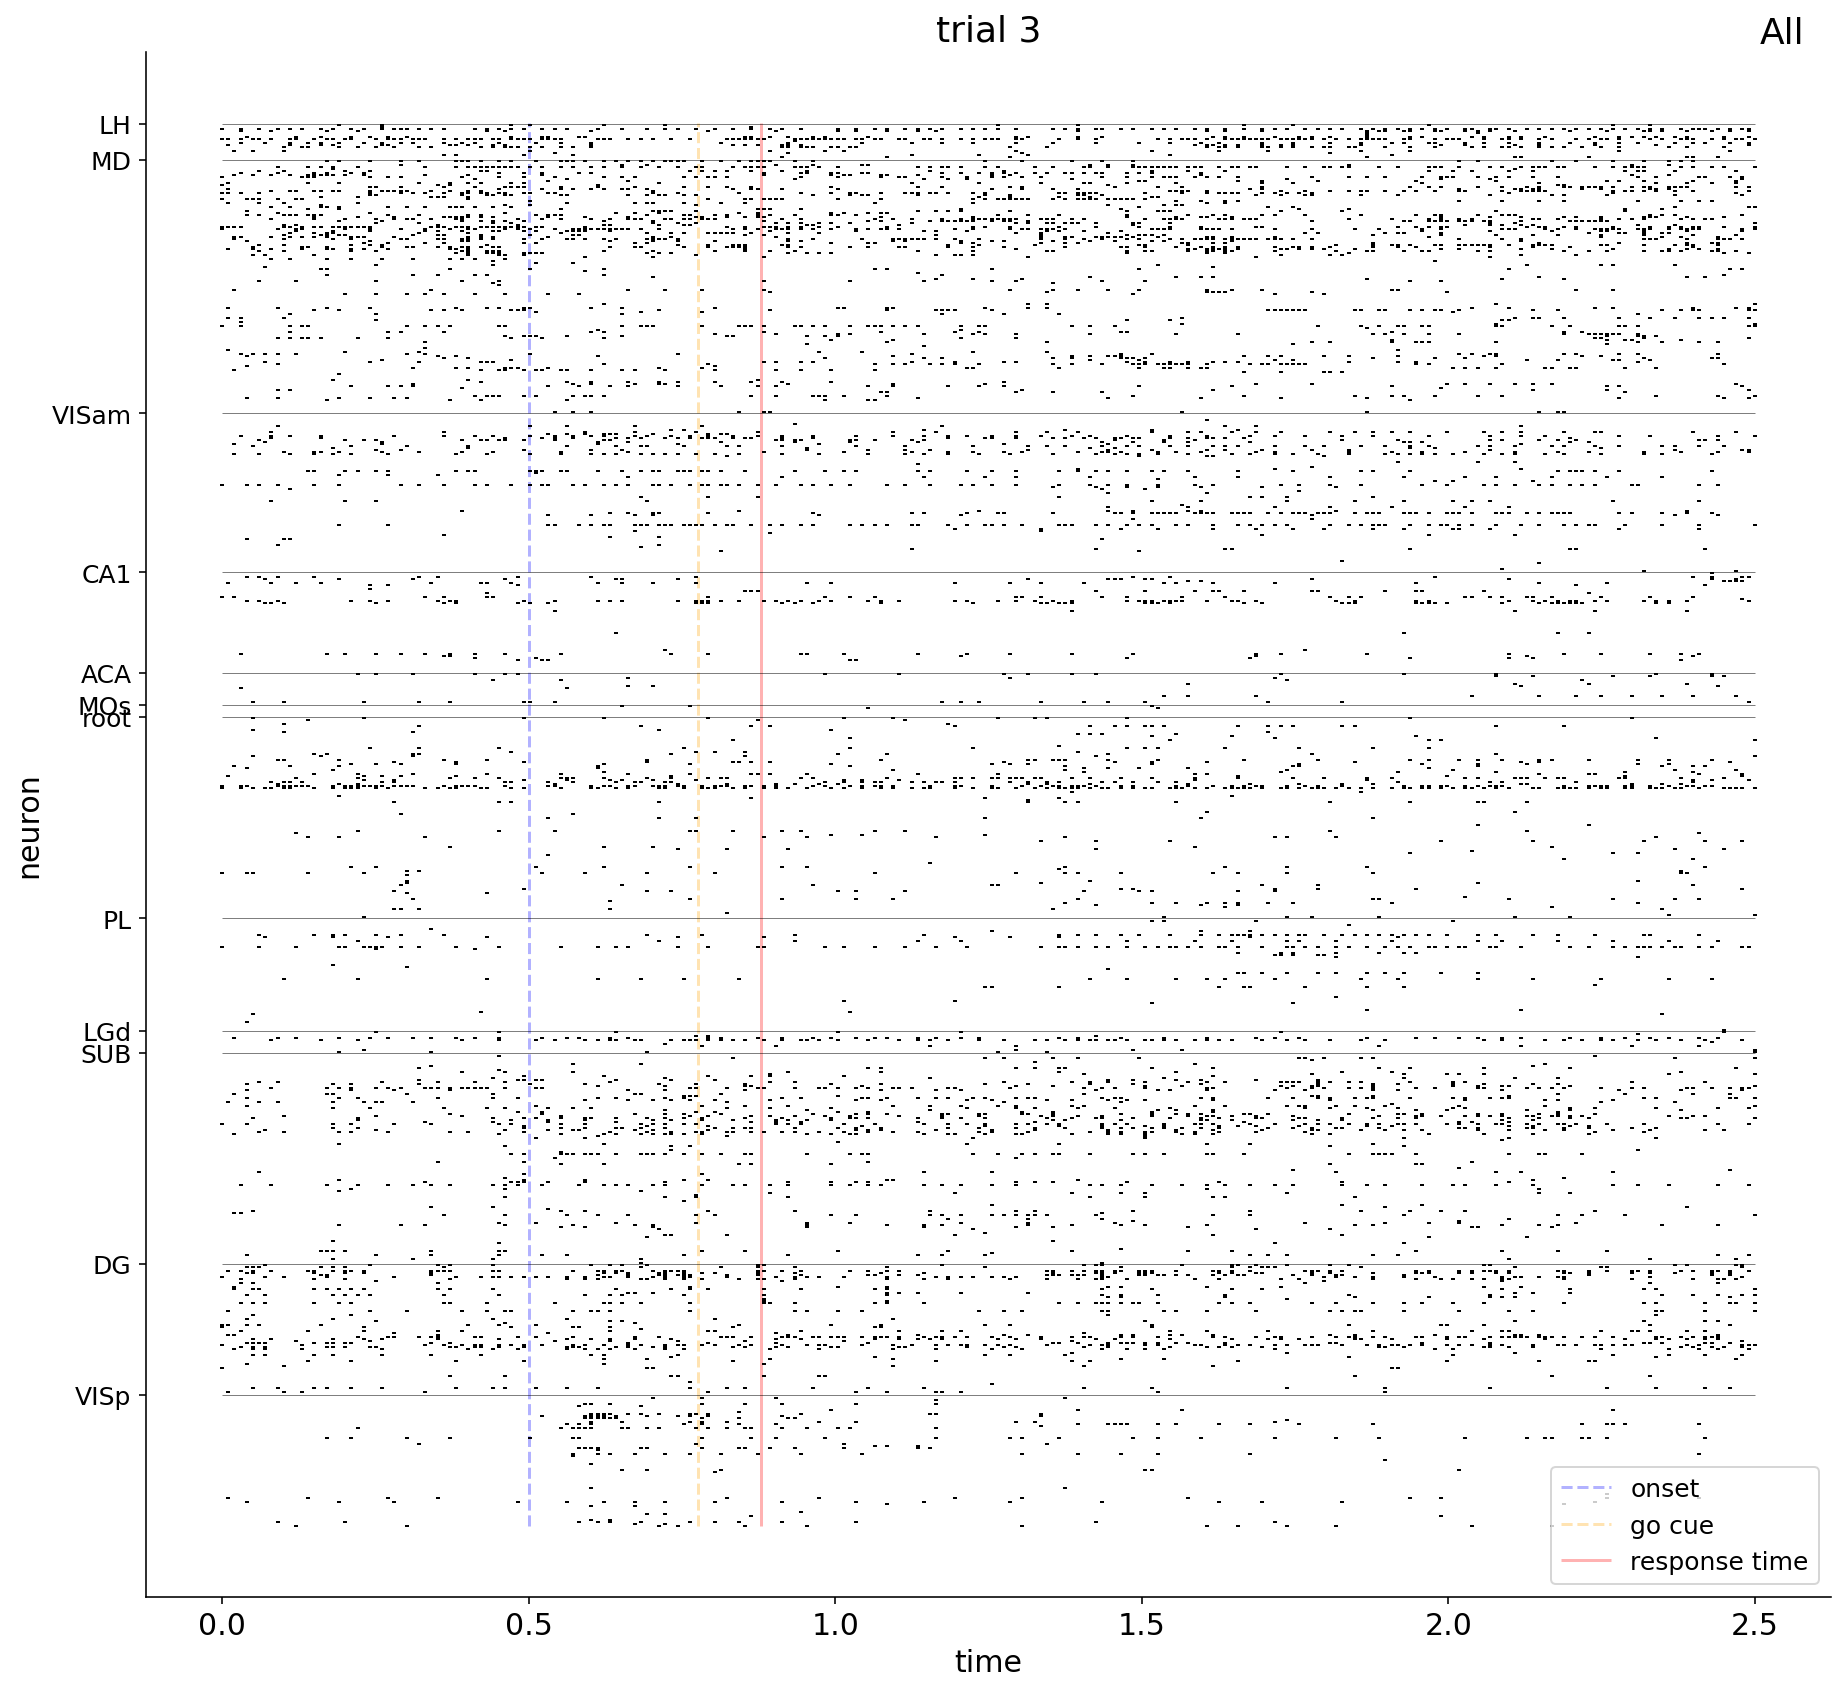

In [ ]:
raster_plot(t_series(3))

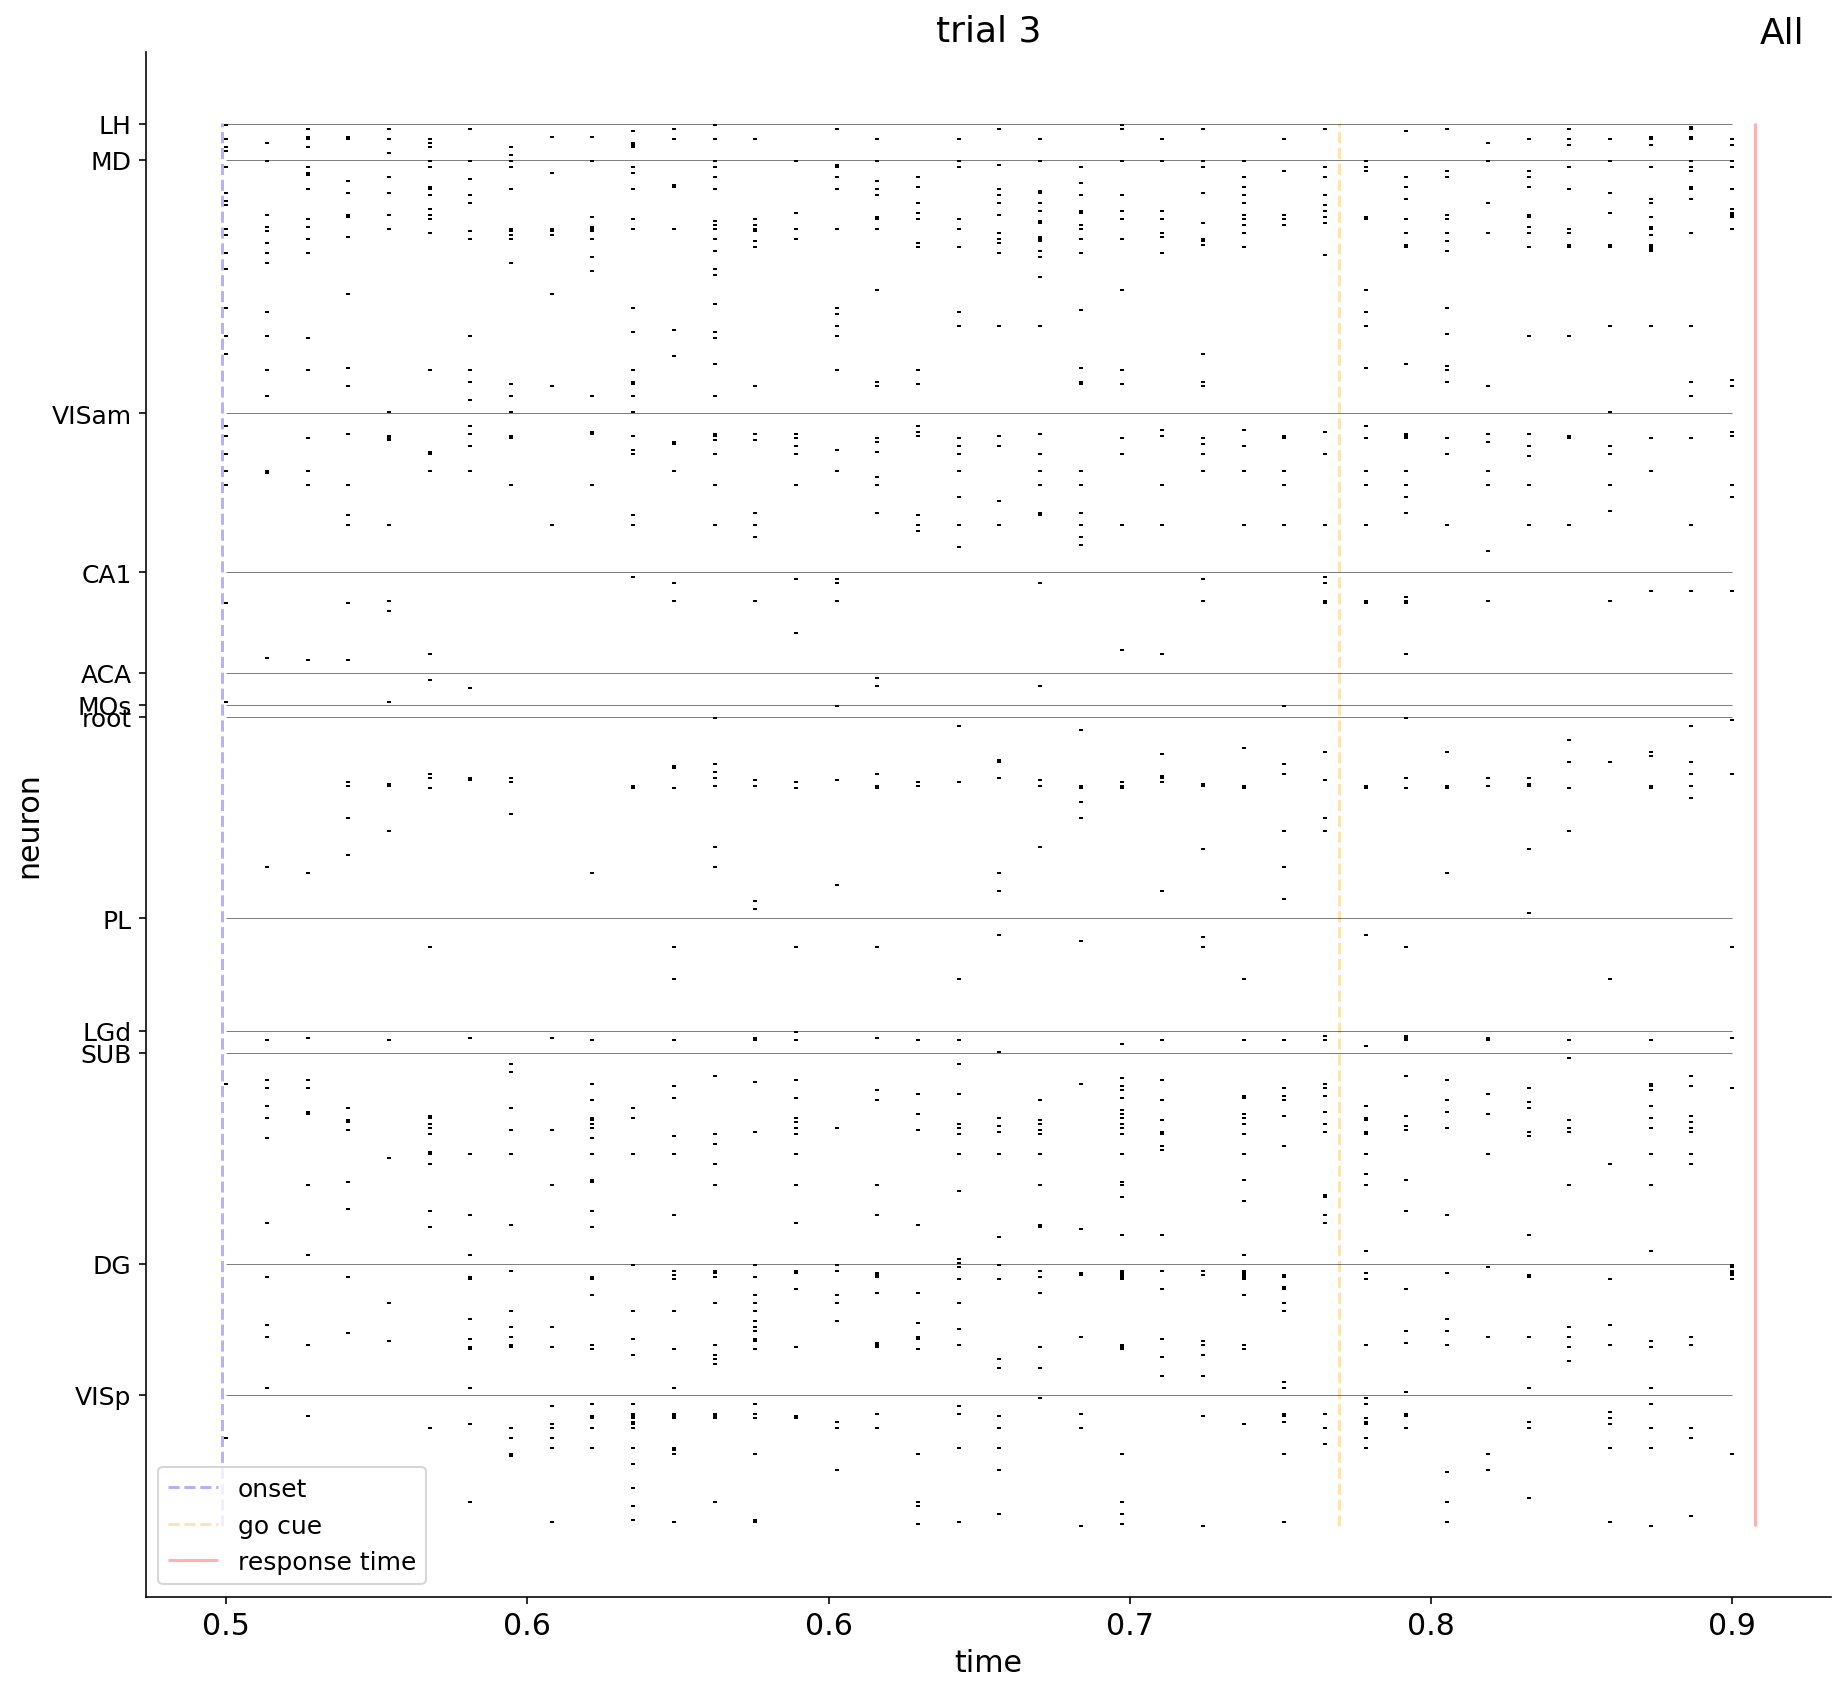

In [ ]:
raster_plot(t_series(3, bins=stim_to_resp(3)))

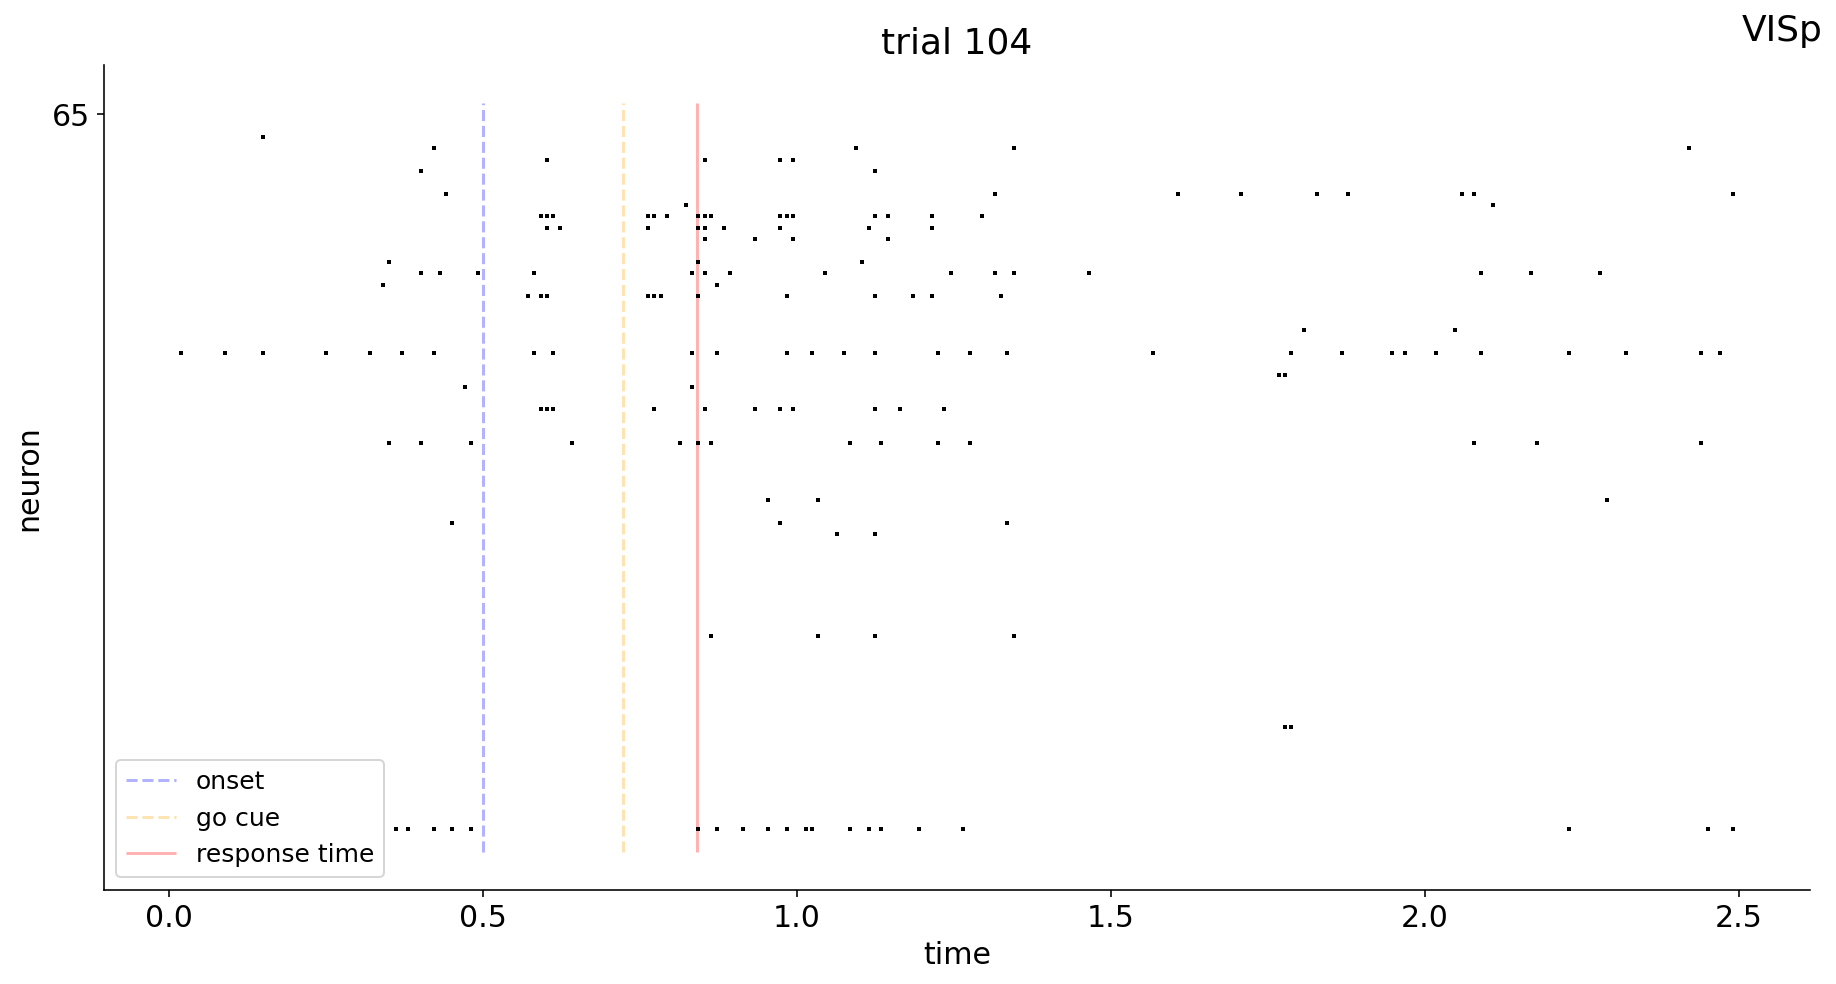

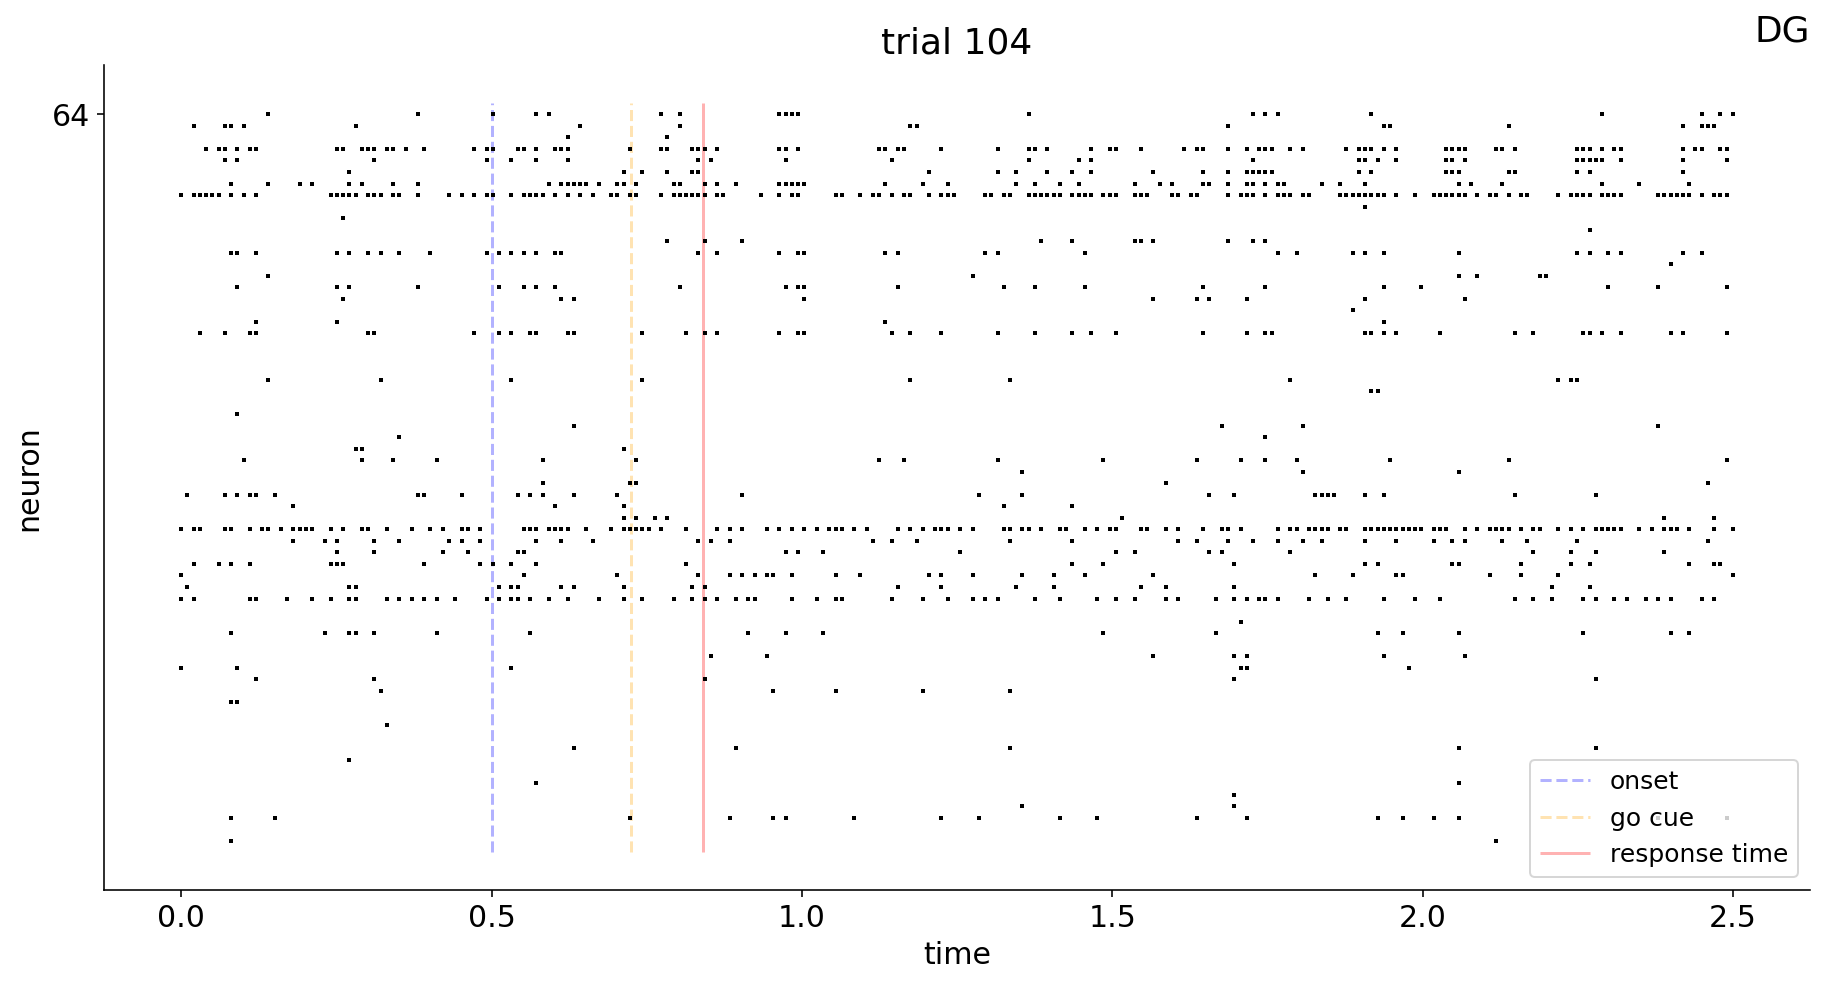

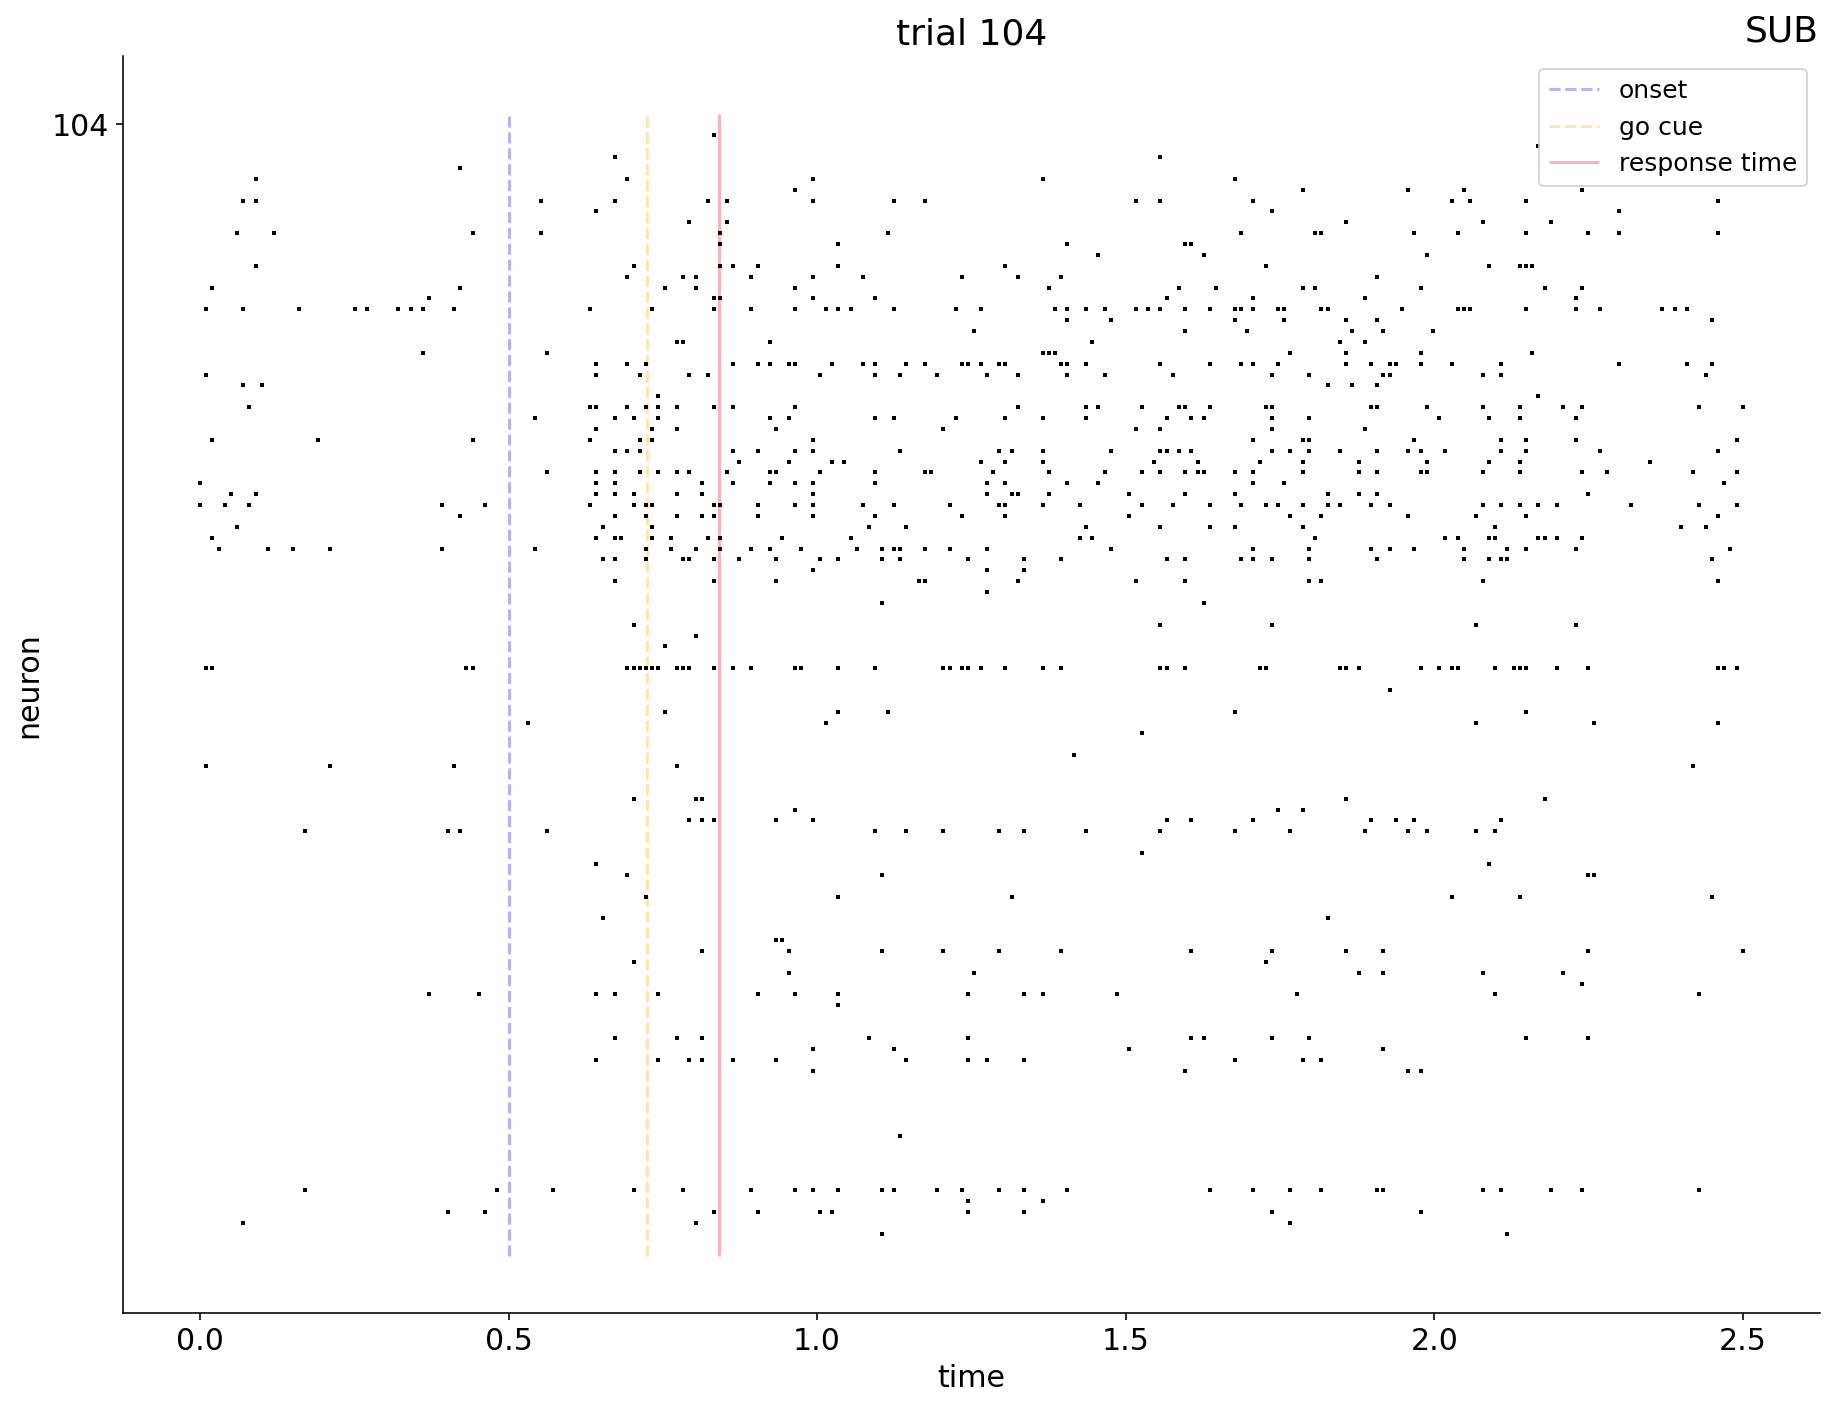

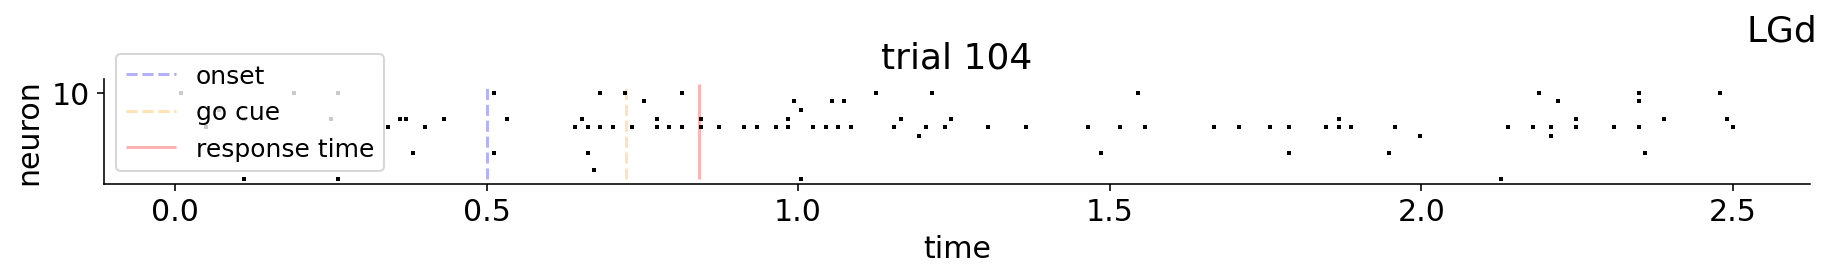

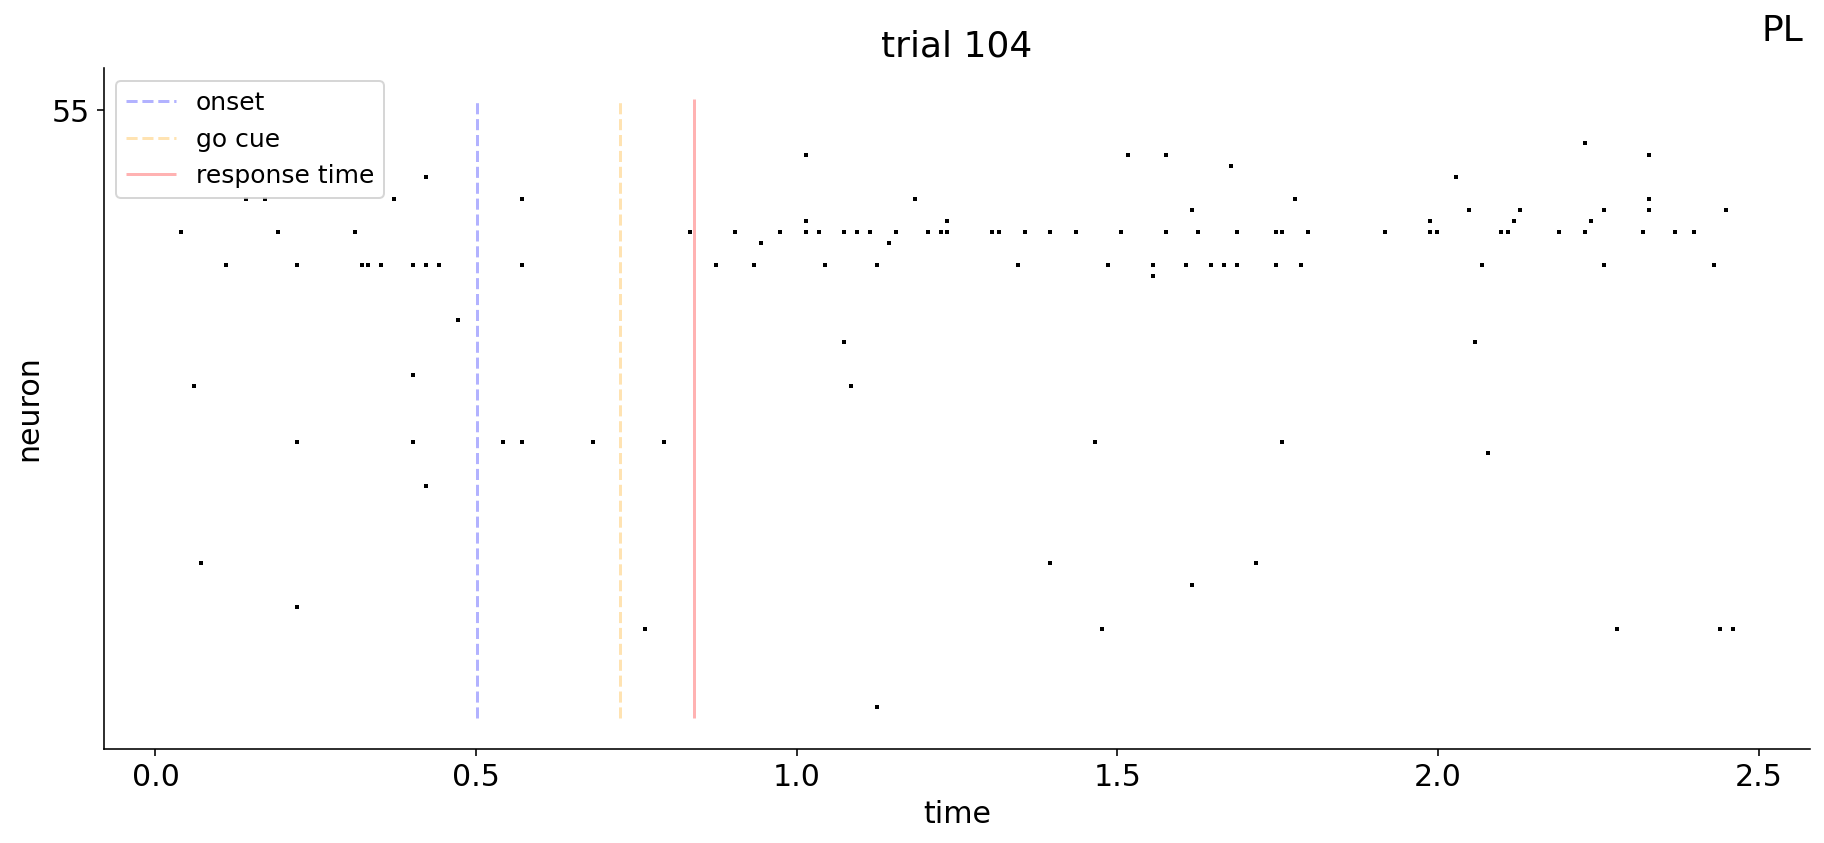

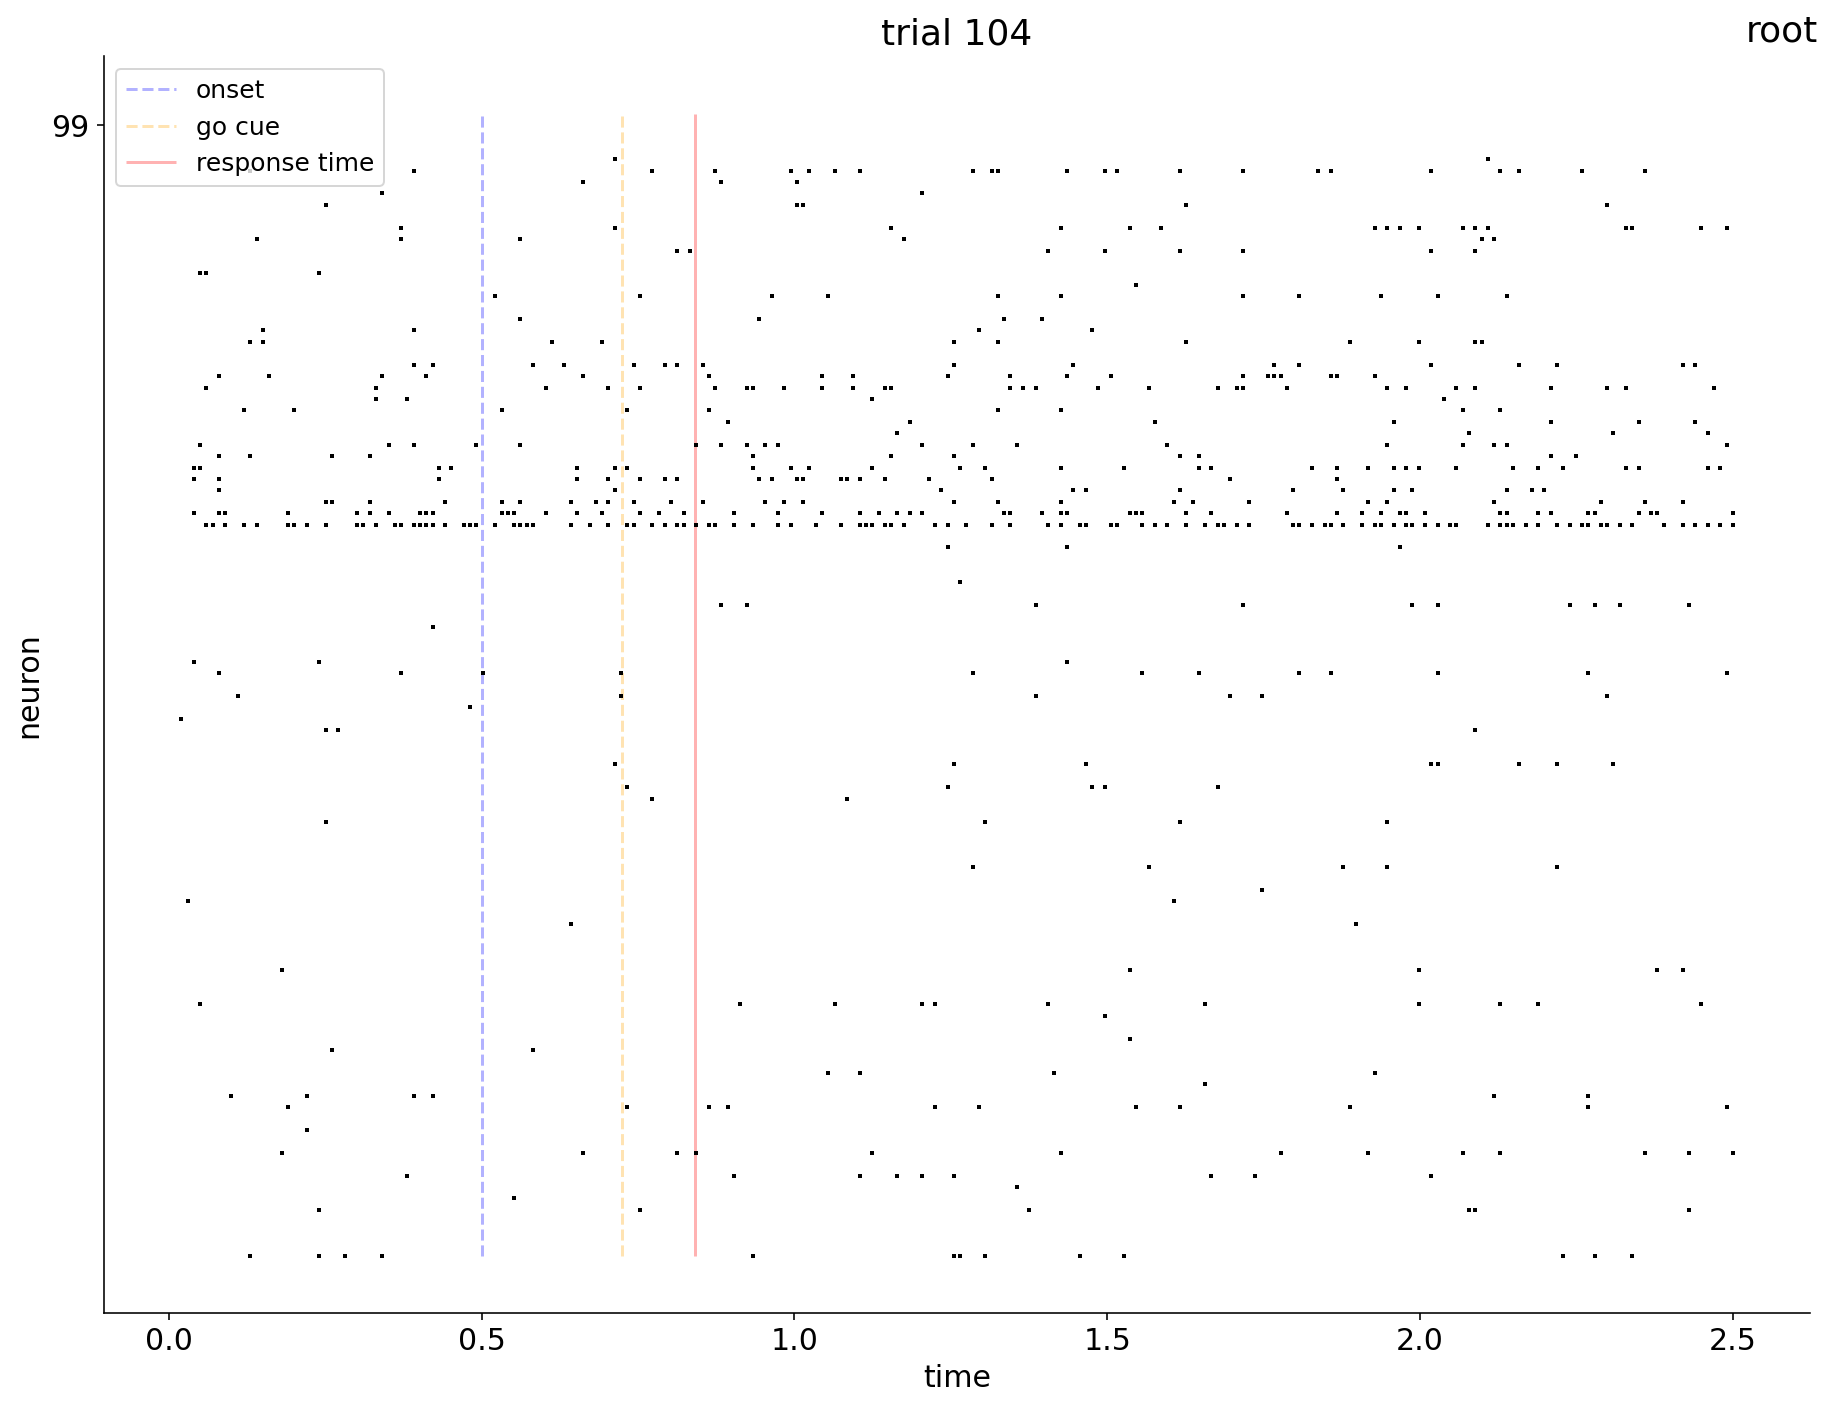

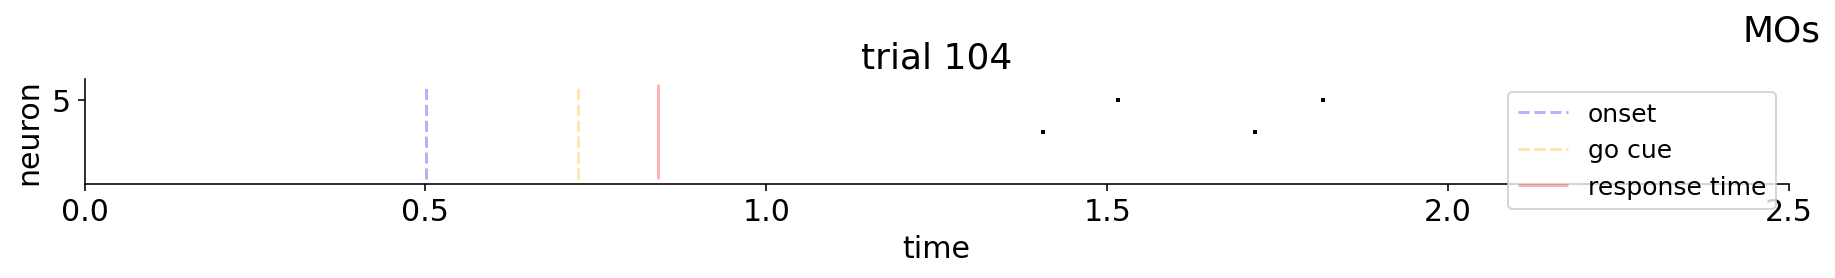

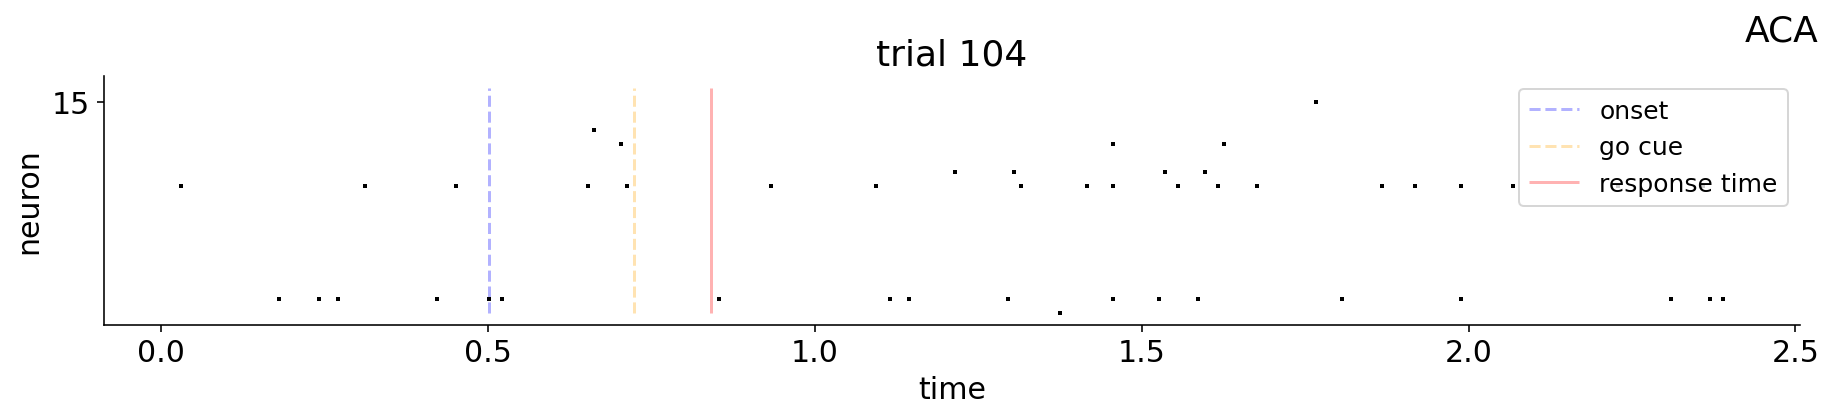

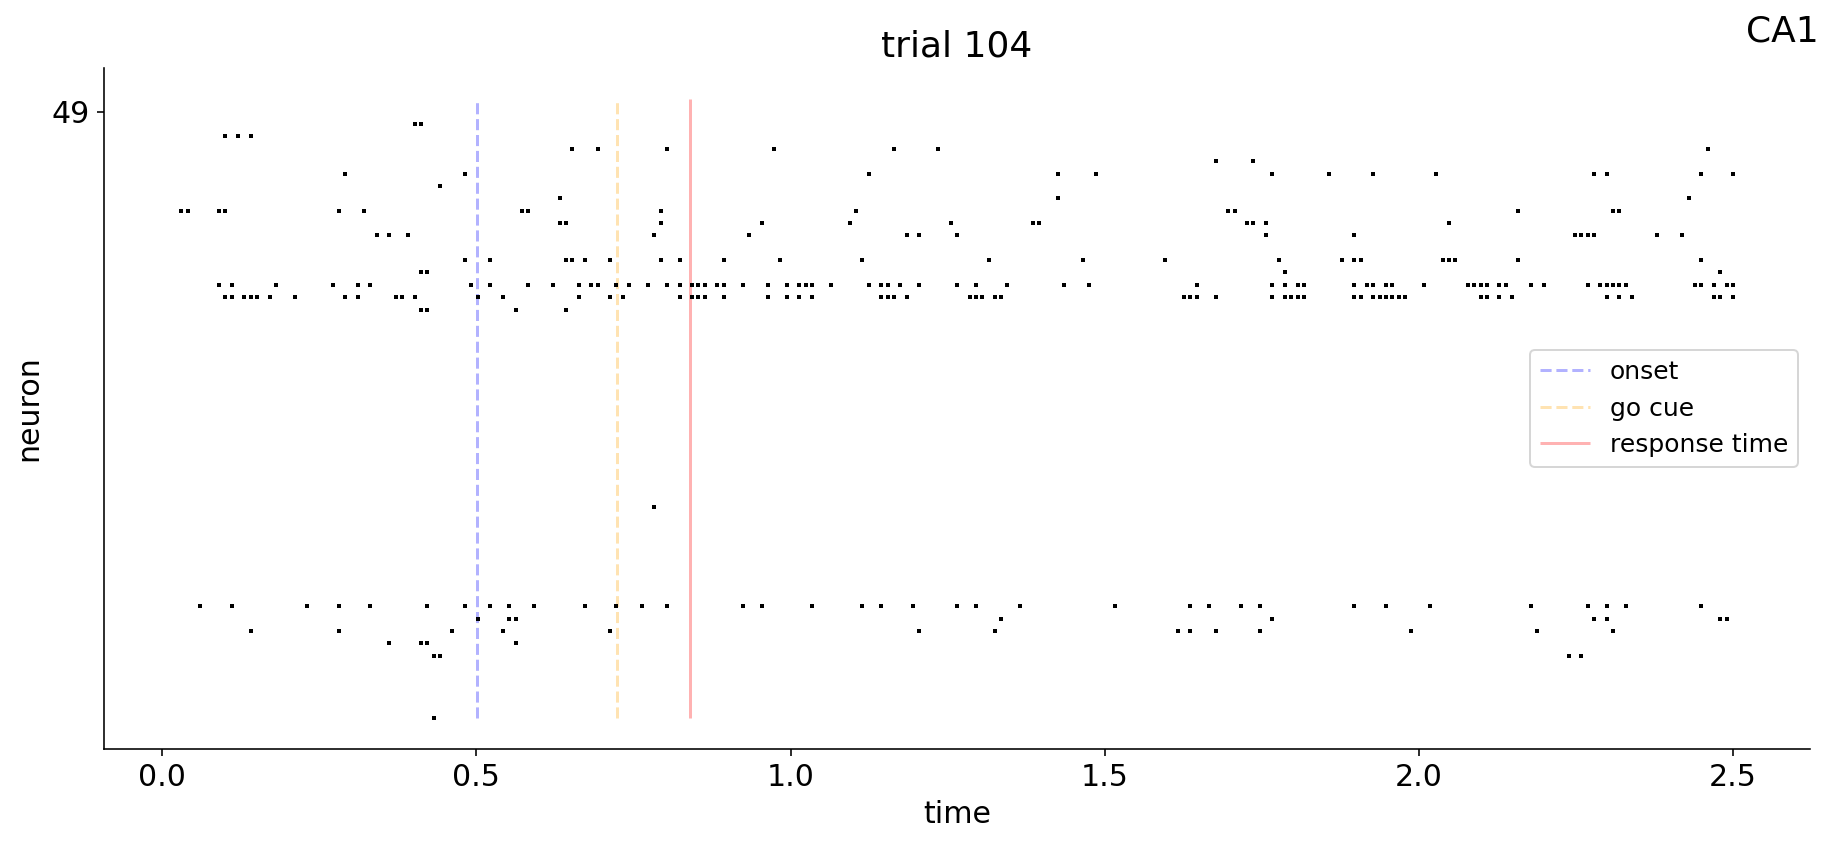

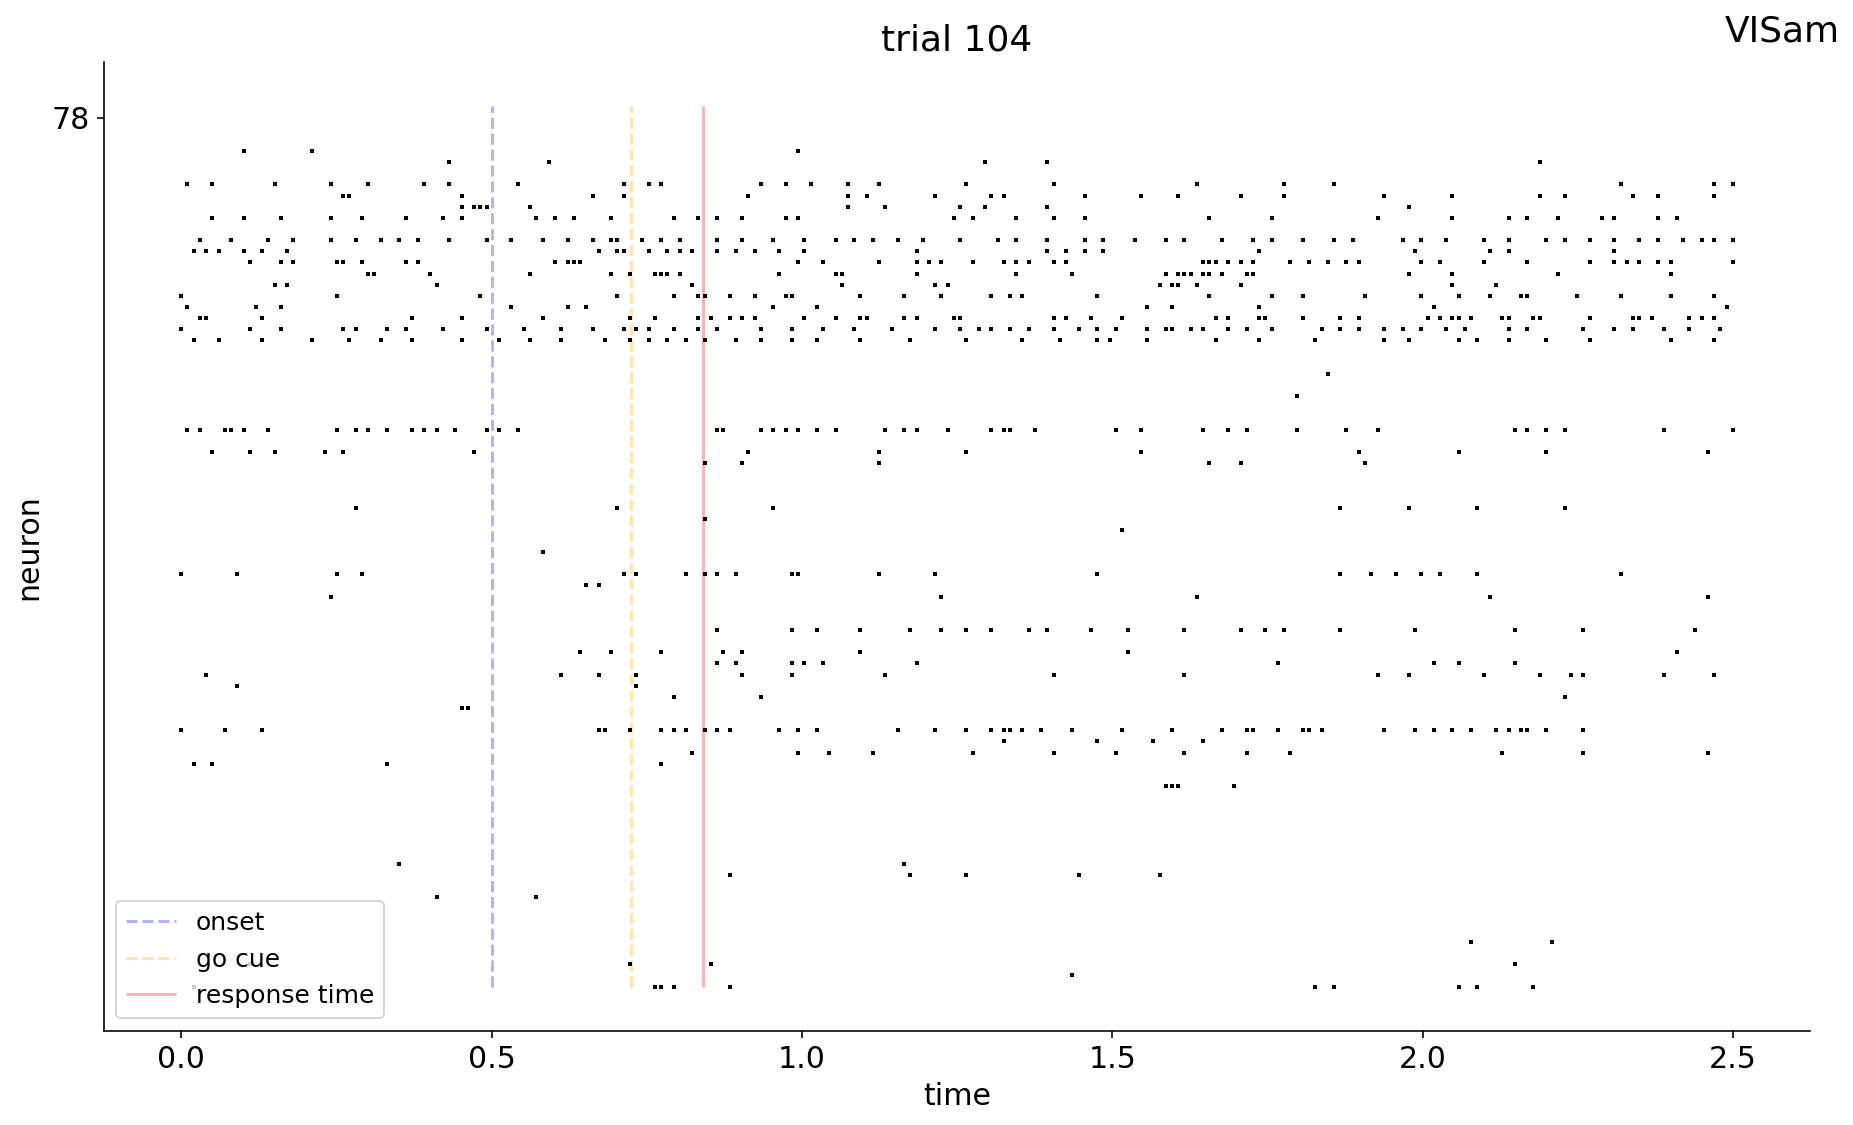

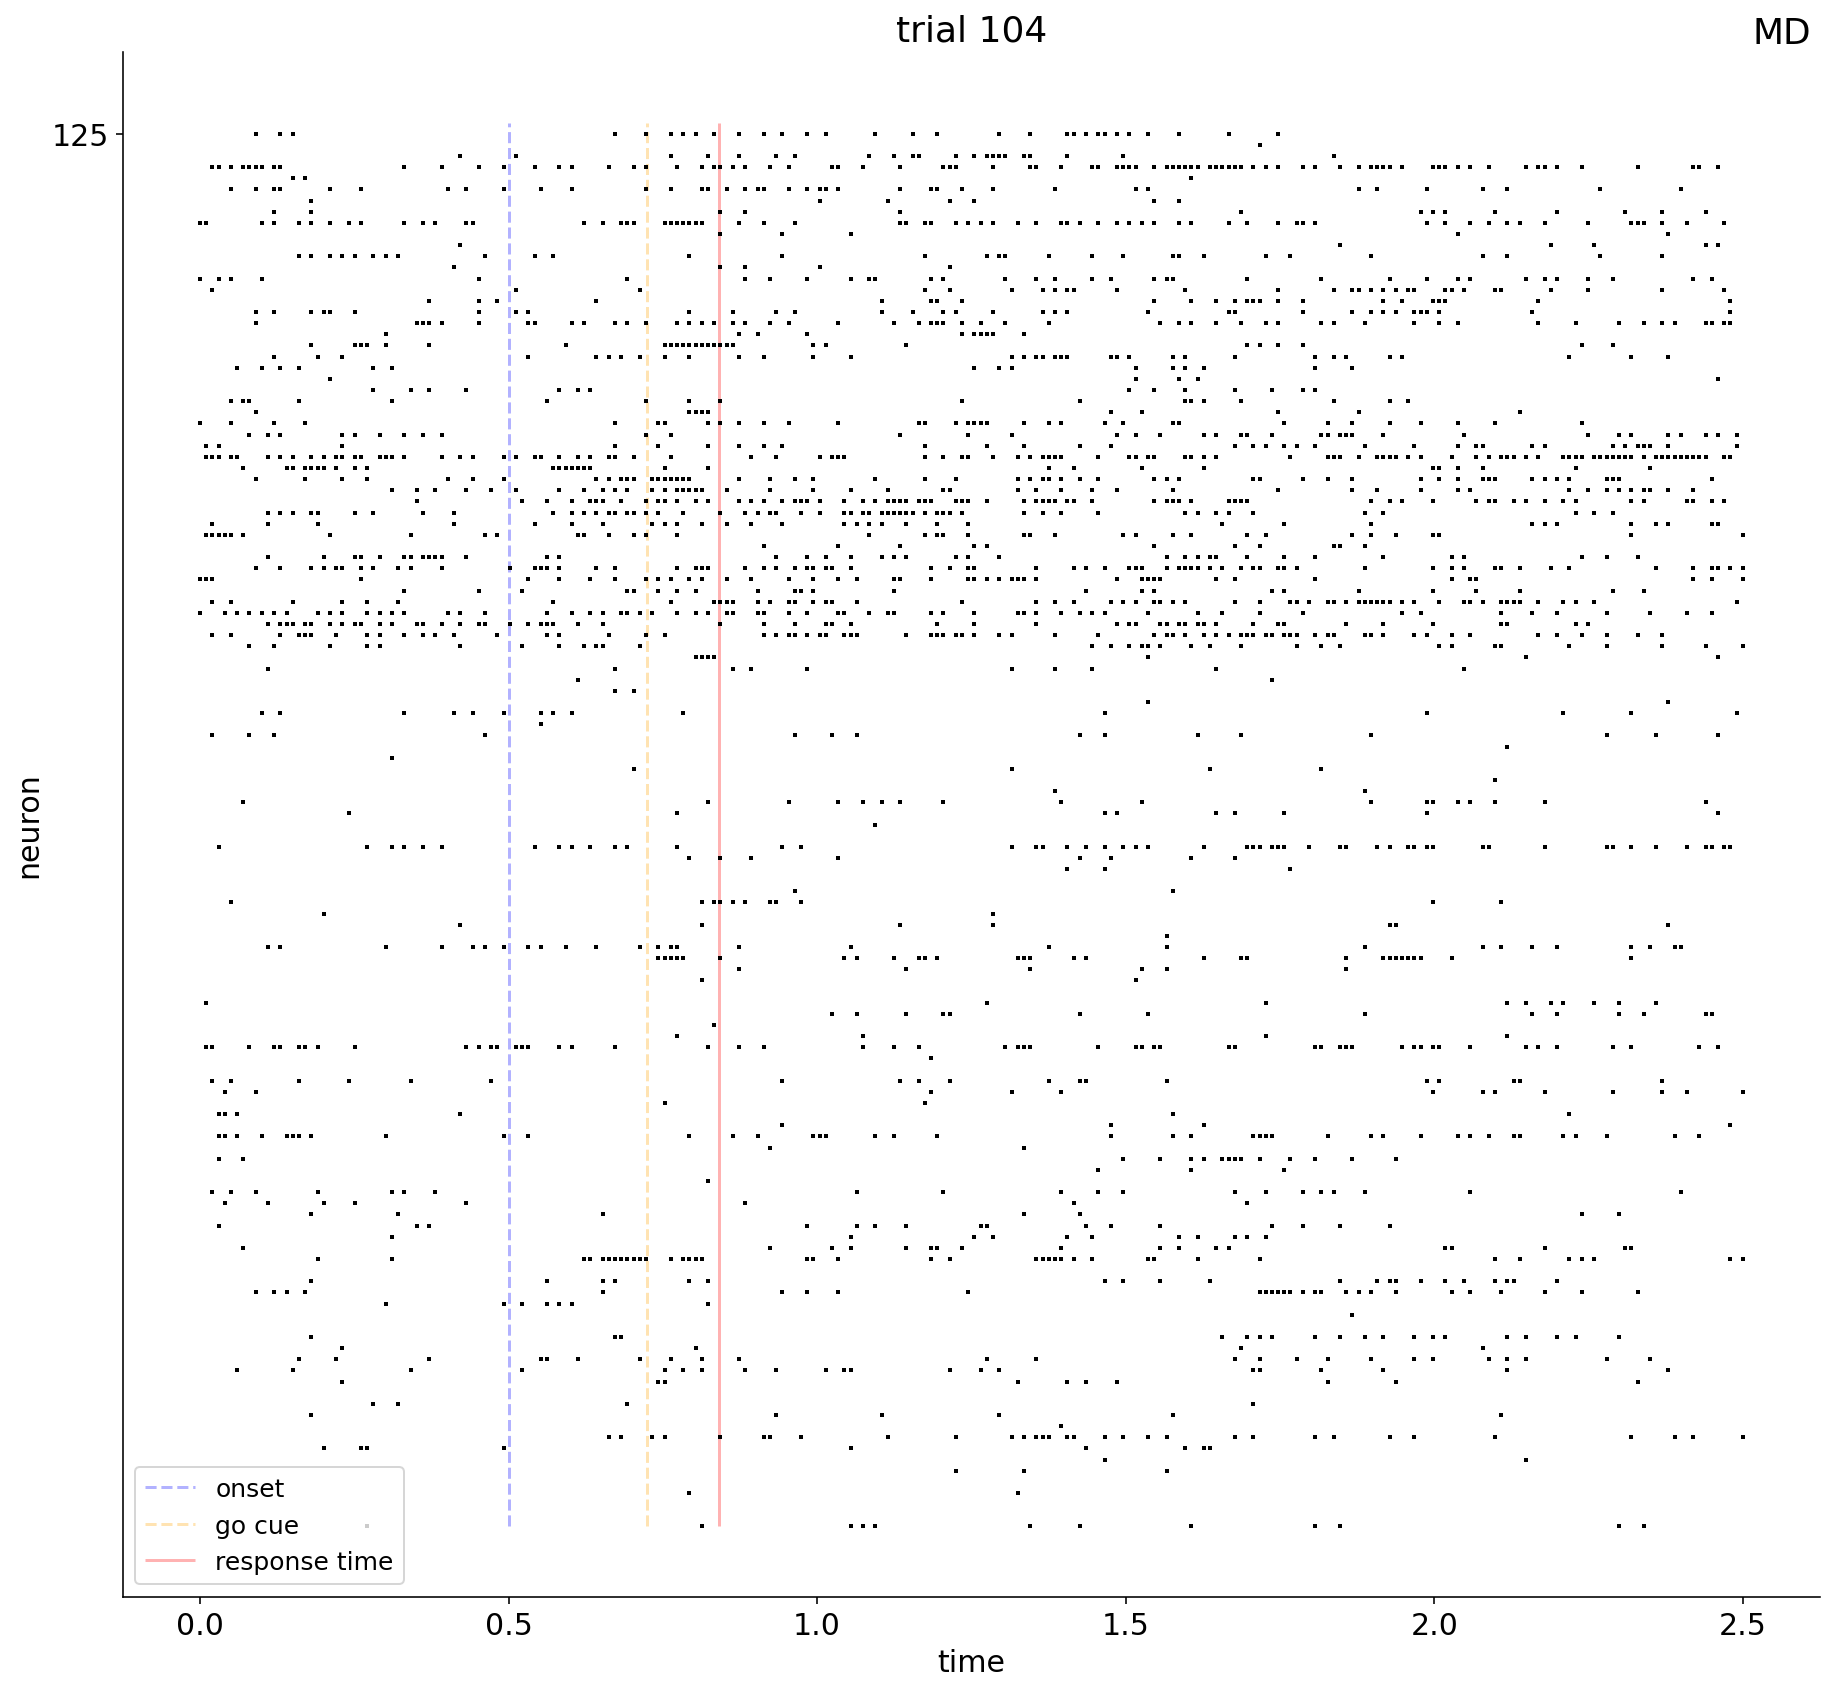

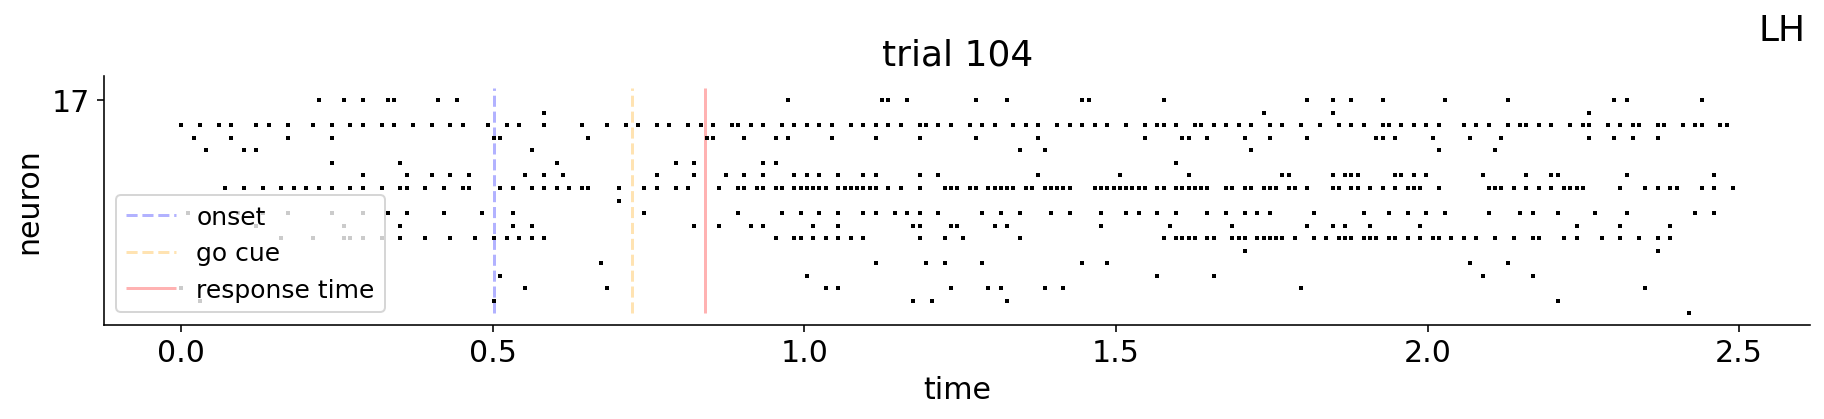

In [ ]:
random_trial = np.random.choice(340, 1)
for area in popul_by_area:
  raster_plot(t_series(area=area, trial=random_trial))

##2. PCA & UMAP

In [ ]:
#@title Global variables { form-width: "25%" }
STIM_ONWARD = np.arange(dat['stim_onset'] / BIN_SIZE, dat['spks'].shape[2], dtype=int)
color_idx = {}

i = 0;
for area in popul_by_area:
  color_idx[area] = i
  i += 1

color_by_area = [color_idx[a] for a in dat['brain_area']]

In [ ]:
#@title Helper functions { form-width: "25%" }

def transform_dat(bins, dat=dat['spks']):
  stitched = dat[:, :, bins].reshape((len(dat), -1))
  neuron_mean = stitched.mean(axis=1)[:, np.newaxis]
  stitched = stitched - neuron_mean
  return stitched.T

def reconstruct_dat_pca(n_components, bins=STIM_ONWARD):
  pca = fit_pca(280, bins)
  transformed = pca.transform(transform_dat(bins))
  reconstructed = pca.inverse_transform(transformed).T
  reconstructed = reconstructed.reshape((dat['spks'].shape[0],
                                         dat['spks'].shape[1],
                                         len(bins)))
  return reconstructed

def fit_pca(n_components, bins):
  pca = PCA(n_components)
  dat = transform_dat(bins)
  pca.fit(dat)
  return pca

def plot_pca(n_components, bins=STIM_ONWARD, cutoff=0.9, mode='cumsum'):
  pca = fit_pca(n_components, bins)
  plt.figure(figsize=(20, 5))

  if mode=='cumsum':
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, n_components+1), cumsum, '-|')
    plt.ylim([0, 1])
    plt.hlines(cutoff, xmin=0, xmax=n_components, color='orange', label='90%')
    plt.vlines(np.argwhere(cumsum >= cutoff)[0], ymin=0, ymax=cutoff, color='b',
               label='%d'%(np.argwhere(cumsum >= cutoff)[0]))
    plt.ylabel('cumulative variance', fontsize=15)
    plt.legend()
  elif mode=='explained':
    explained = pca.explained_variance_
    plt.stem(explained)
    plt.ylabel('explained variance', fontsize=15)
  else:
    raise ValueError('mode must be either "cumsum" or "explained"!')

  plt.xticks(range(1, n_components+1, 10 * (n_components // 100)))
  plt.xlabel('PC', fontsize=15)
  plt.show()

def get_umap_embedding(bins, mode, random_state):
  
  reducer = umap.UMAP(random_state=random_state)
  dat_reduced = transform_dat(bins).T
  reducer.fit(dat_reduced)

  if mode=='unsupervised':
    embedding = reducer.transform(dat_reduced)
  elif mode=='supervised':
    embedding = reducer.fit_transform(dat_reduced, y=dat['brain_area'])
  else:
    raise ValueError('mode must either be supervised or unsupervised!')

  return embedding

def plot_umap(bins=STIM_ONWARD, mode='unsupervised', random_state=42):
  embedding = get_umap_embedding(bins, mode, random_state)
  fig, ax = plt.subplots(1, figsize=(10, 7))
  plt.scatter(x=embedding[:, 0], y=embedding[:, 1], s=15,
              c=color_by_area, cmap='Paired')
  cbar = plt.colorbar(boundaries=np.arange(len(color_idx)+1)-0.5)
  cbar.set_ticks(np.arange(len(color_idx)))
  cbar.set_ticklabels(list(color_idx.keys()))
  plt.setp(ax, xticks=[], yticks=[])
  plt.title('UMAP, mode = {}'.format(mode))
  plt.show()

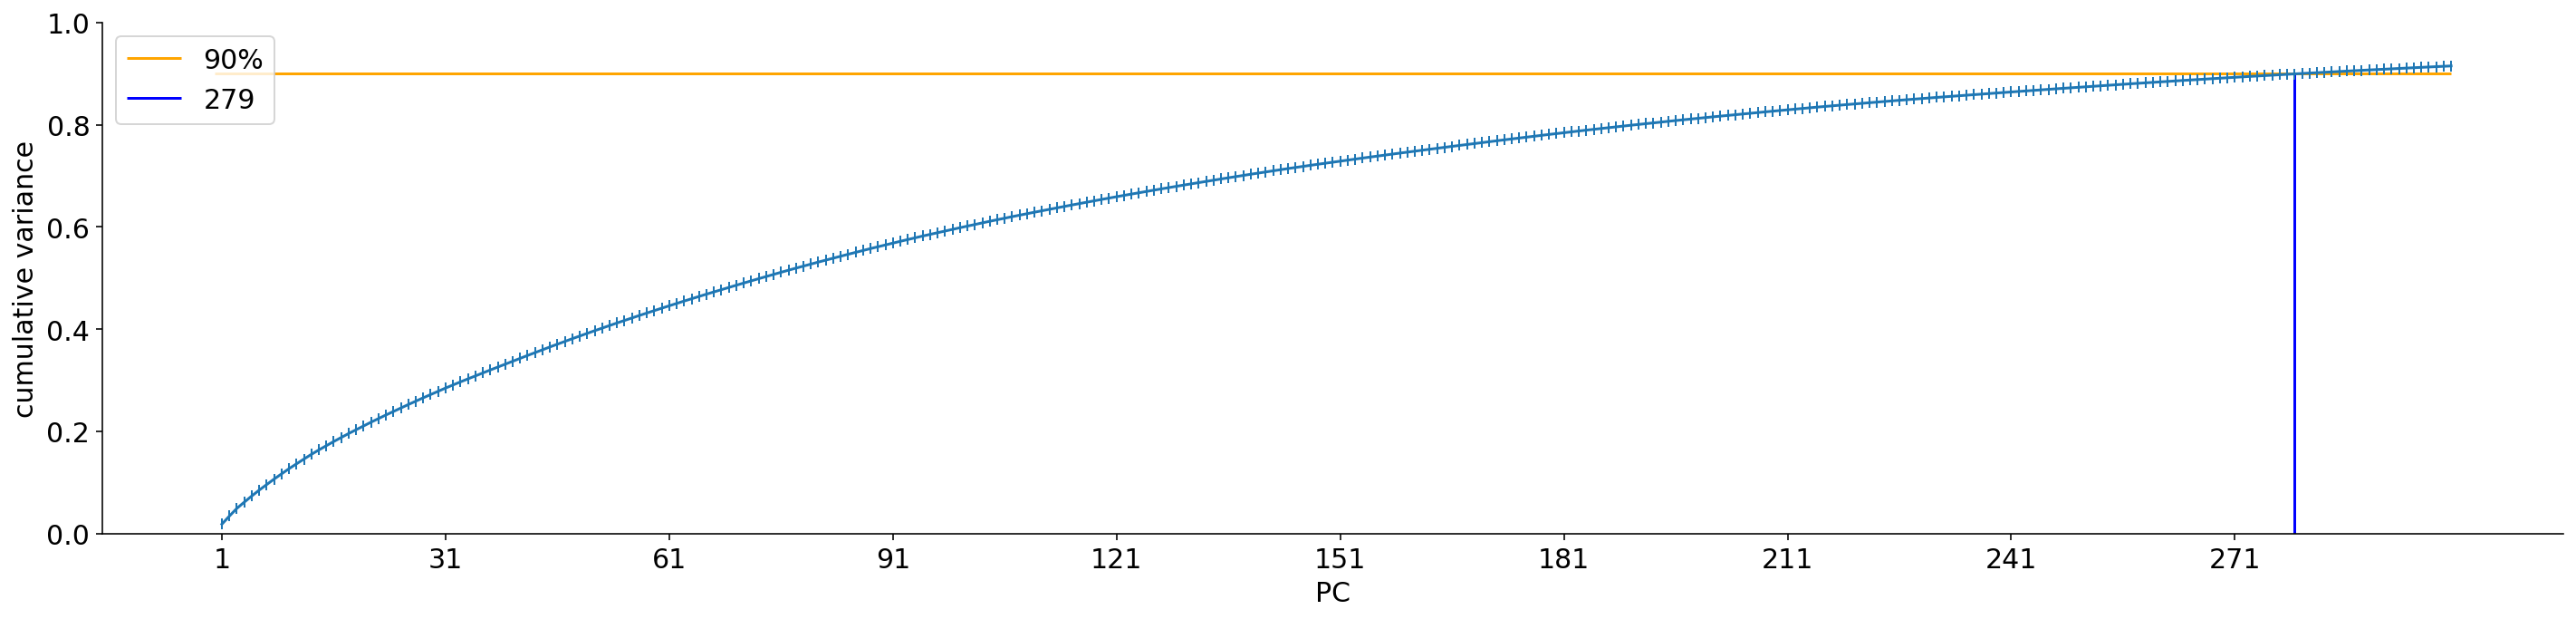

In [ ]:
plot_pca(300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


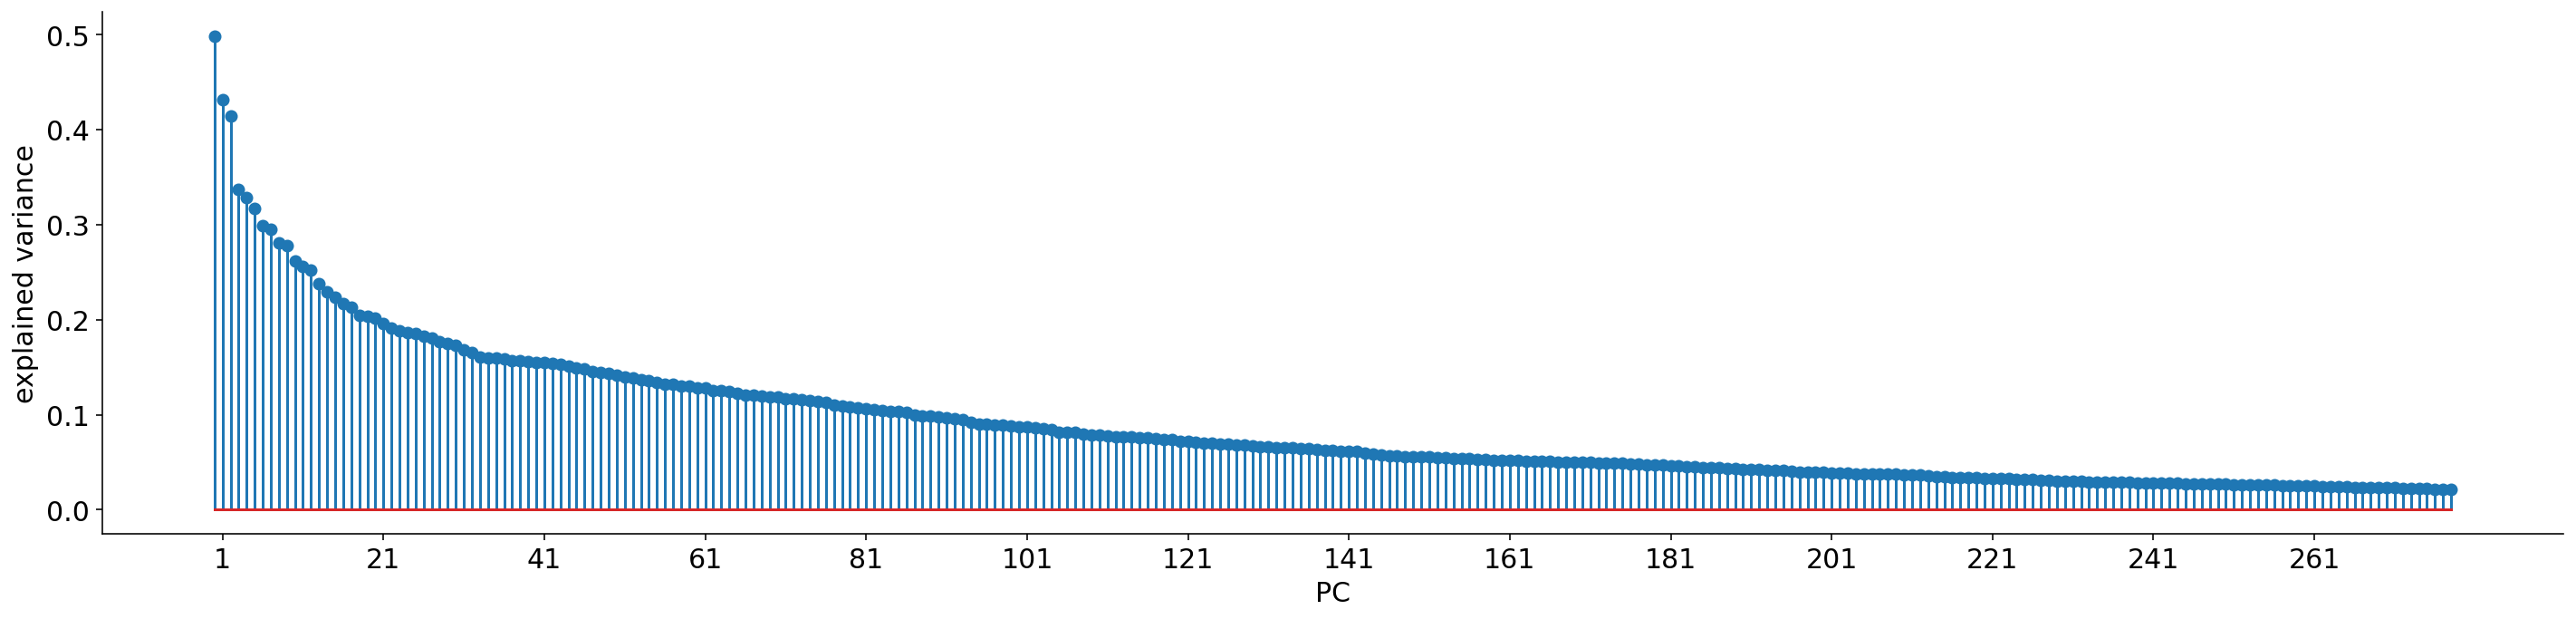

In [ ]:
plot_pca(279, mode='explained')

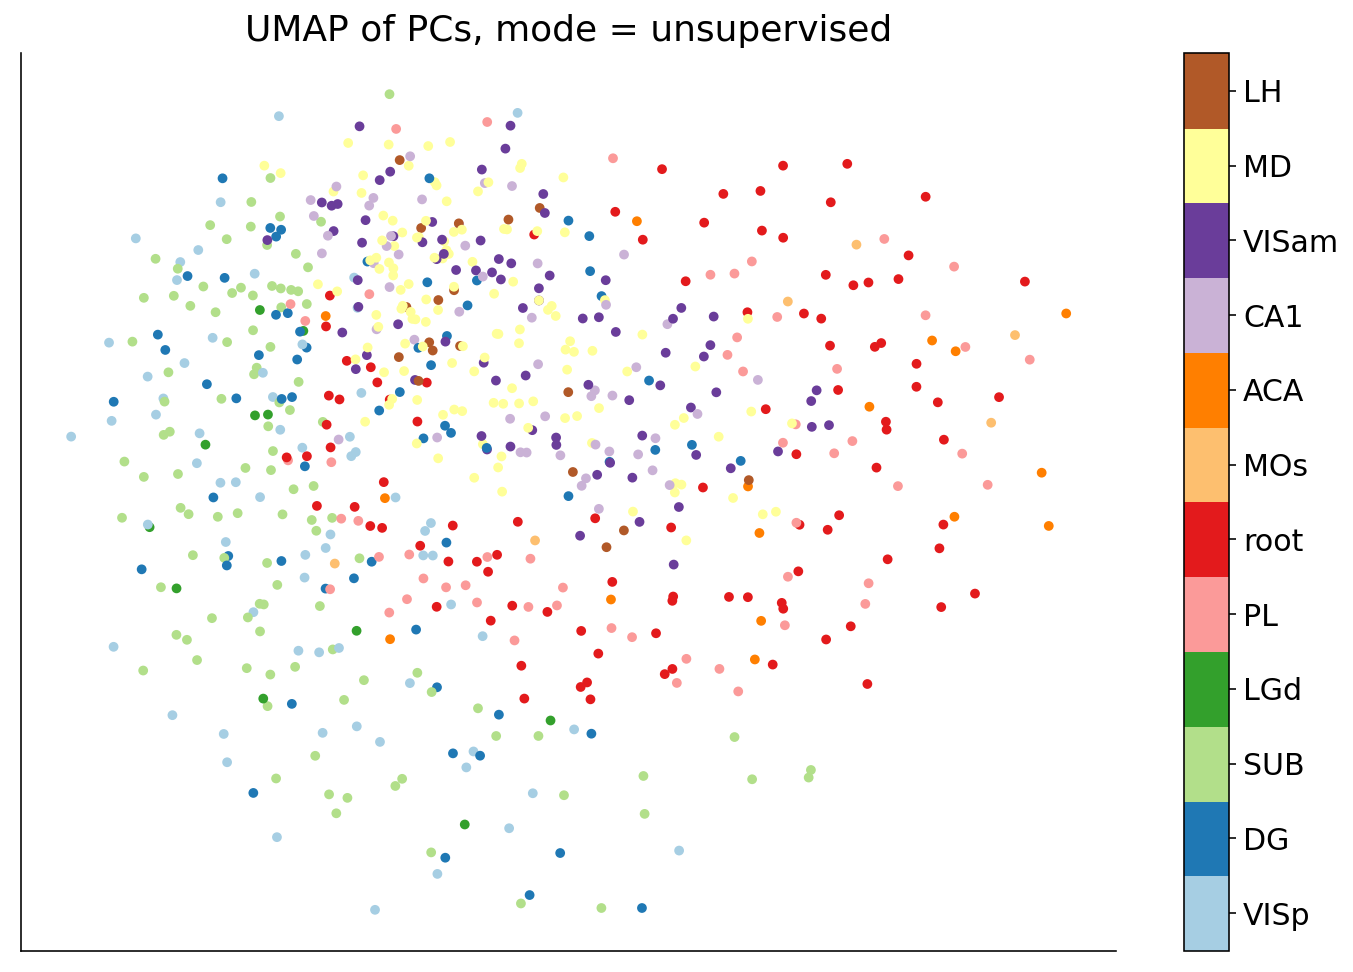

In [ ]:
plot_umap(mode='unsupervised')

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1867: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  y_ = check_array(y, ensure_2d=False)[index]


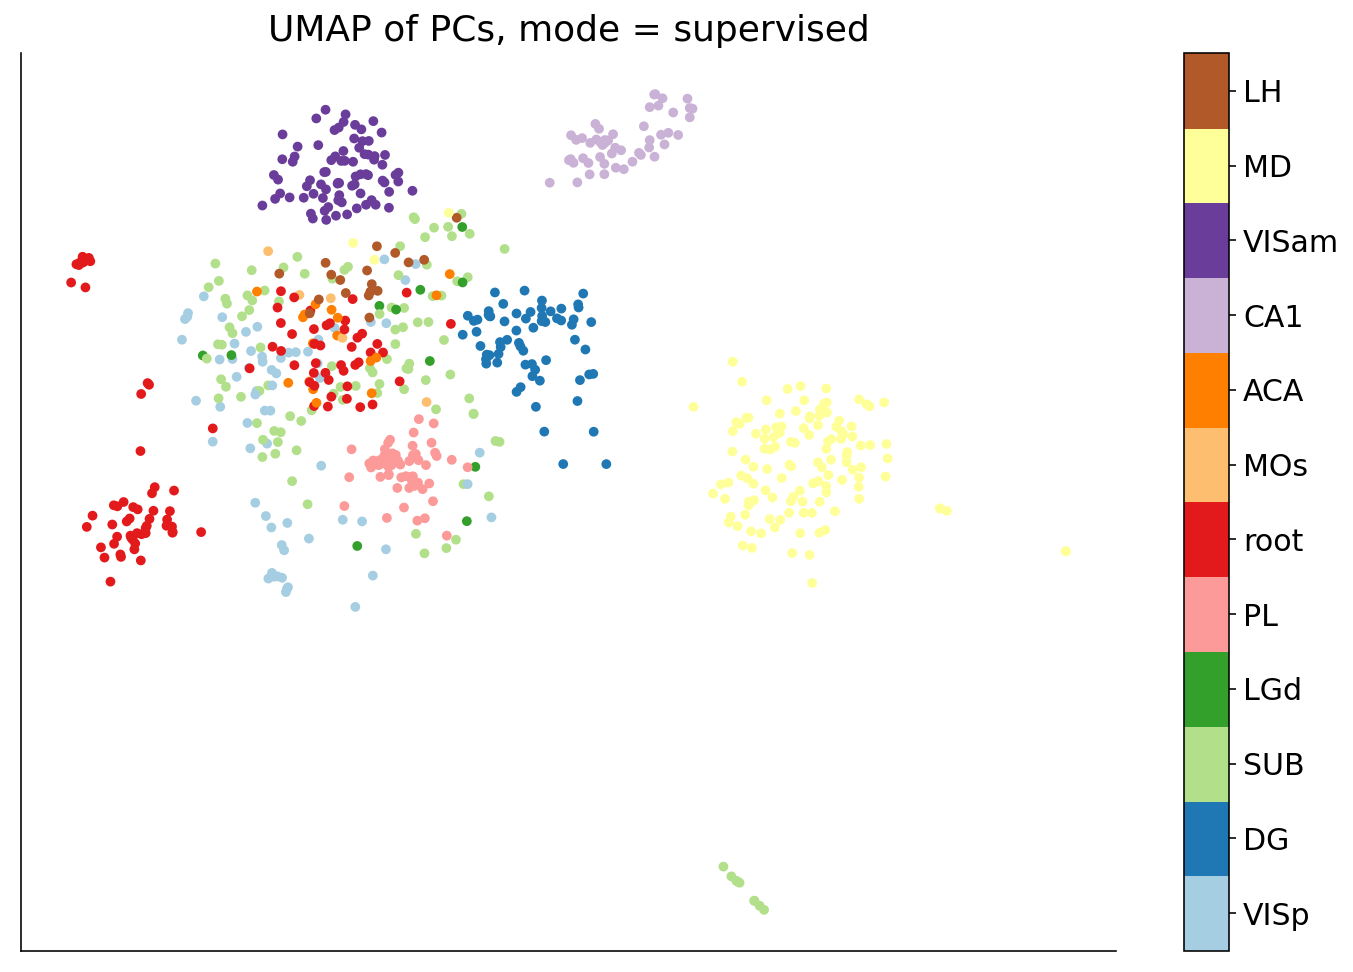

In [ ]:
plot_umap(mode='supervised')

##3. Firing Rates from PCA-filtered Data

In [ ]:
def plot_firing_rates(data, title):
  neurons, _, bins = data.shape
  mean_rate = np.zeros((neurons, bins))
  for n, neuron in enumerate(data):
    mean_rate[n] = 1/BIN_SIZE * neuron.mean(axis=0)
  
  a_list = list(popul_by_area.keys())
  yticks = [0]
  y_idx = 0
  for a in a_list[0:]:
    y_idx += len(popul_by_area[a])
    yticks.append(y_idx)

  plt.figure(figsize=(15, 7))
  plt.vlines(dat['stim_onset'] / BIN_SIZE, ymin=0, ymax=neurons, 
             color='k', label='stim onset', linewidth=0.8)
  plt.yticks(yticks, labels=a_list, fontsize='xx-small')
  plt.imshow(mean_rate, aspect='auto', cmap='inferno', vmin=-20, vmax=75)
  plt.legend(bbox_to_anchor=(0.2, 1.05), fontsize='xx-small')
  plt.title(title)
  plt.colorbar(label='mean firing rate (Hz)')
  print('Min rate:', mean_rate.min())
  print('Max rate:', mean_rate.max())

Min rate: 0.0
Max rate: 72.35294117647058


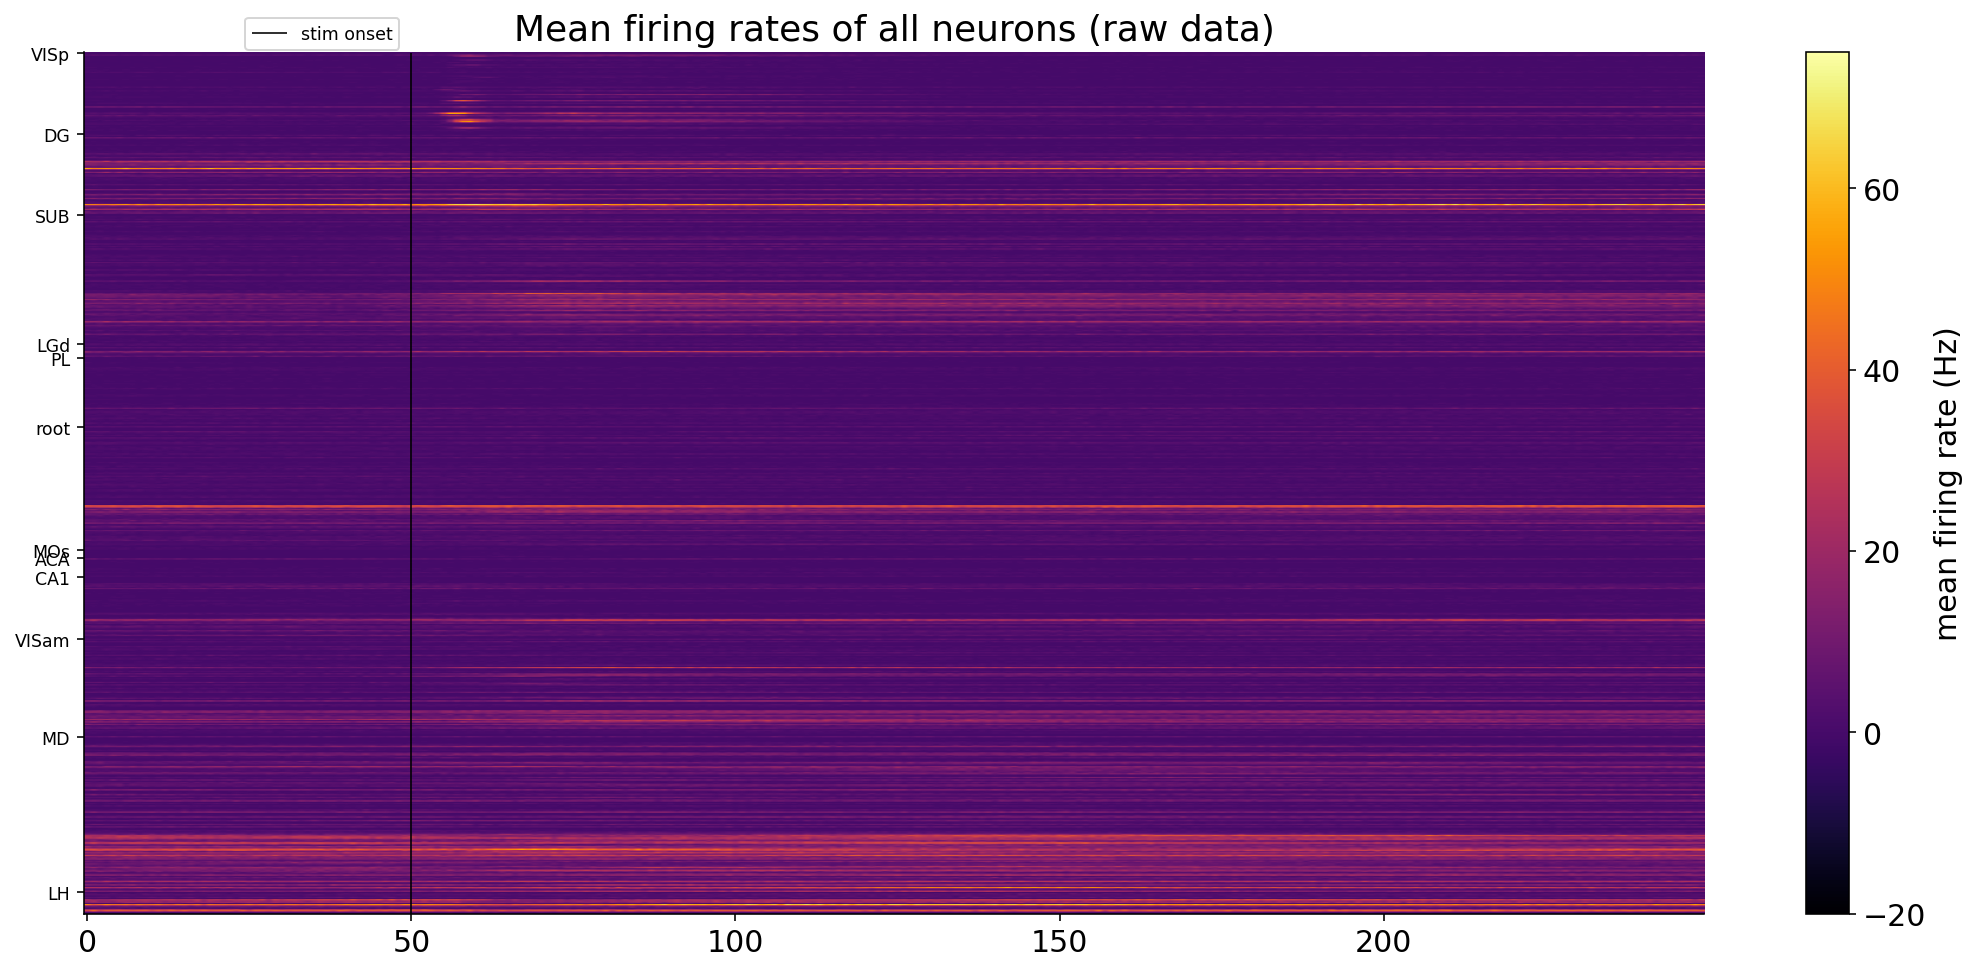

In [ ]:
plot_firing_rates(order_data(), 'Mean firing rates of all neurons (raw data)')

In [ ]:
pca_filtered = order_data(data=reconstruct_dat_pca(279, bins=range(0, 250)))

Min rate: -19.201122975928037
Max rate: 58.258017461804435


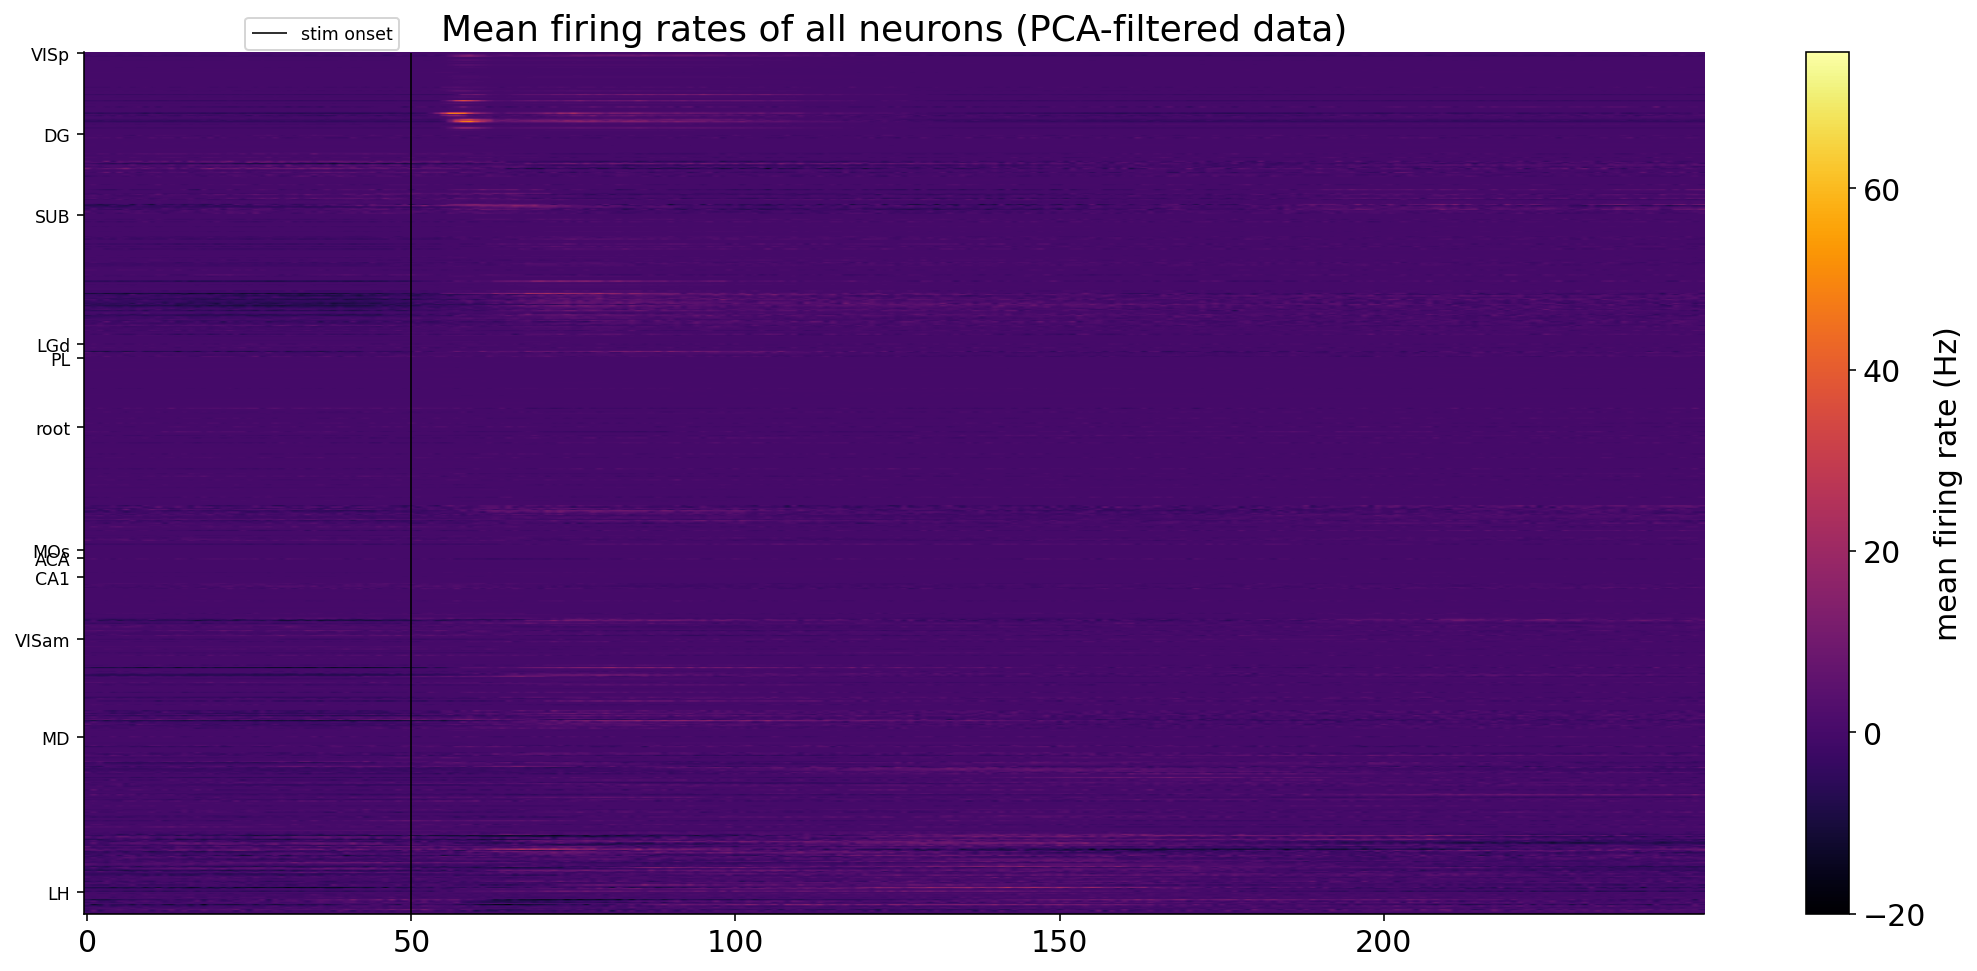

In [ ]:
plot_firing_rates(pca_filtered, 
                  'Mean firing rates of all neurons (PCA-filtered data)')

(array([ 21.,  20.,  37.,  25.,   0., 126.,  24.,  28.,  24.,  35.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

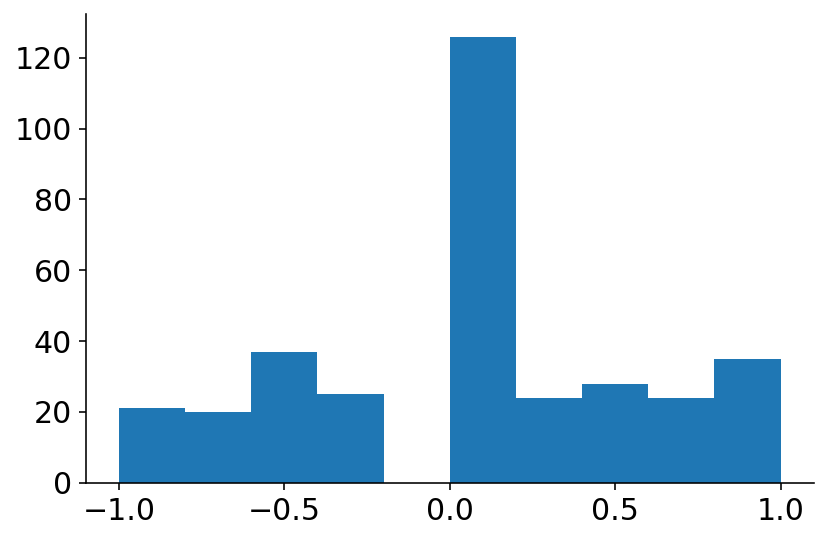

In [ ]:
contrasts = dat['contrast_right'] - dat['contrast_left']
plt.hist(contrasts)

In [ ]:
np.corrcoef(np.abs(contrasts), correctness)

array([[1.        , 0.37012929],
       [0.37012929, 1.        ]])

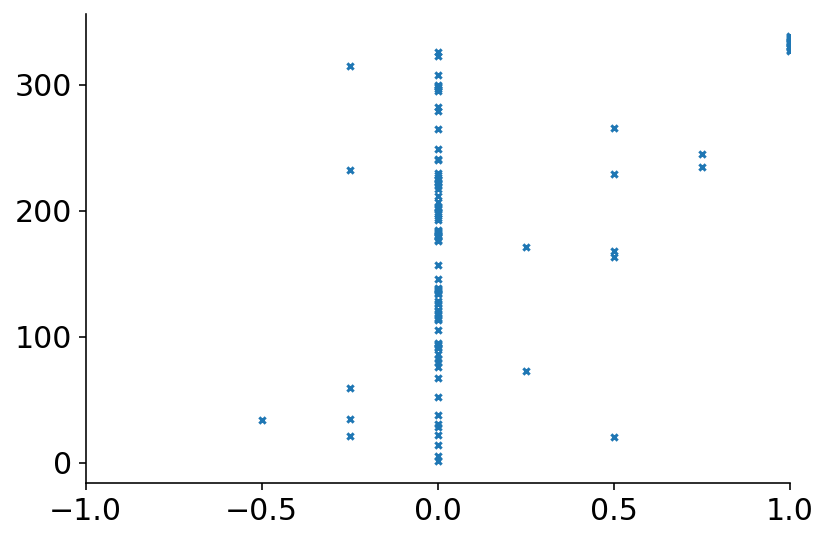

In [ ]:
wrongs = np.argwhere(correctness==0).flatten()
rights = np.argwhere(correctness==1).flatten()
plt.xlim([-1, 1])
plt.scatter(x=contrasts[wrongs], y=wrongs, s=10, marker='x')

Min rate: -26.25887185972505
Max rate: 61.50868381667283


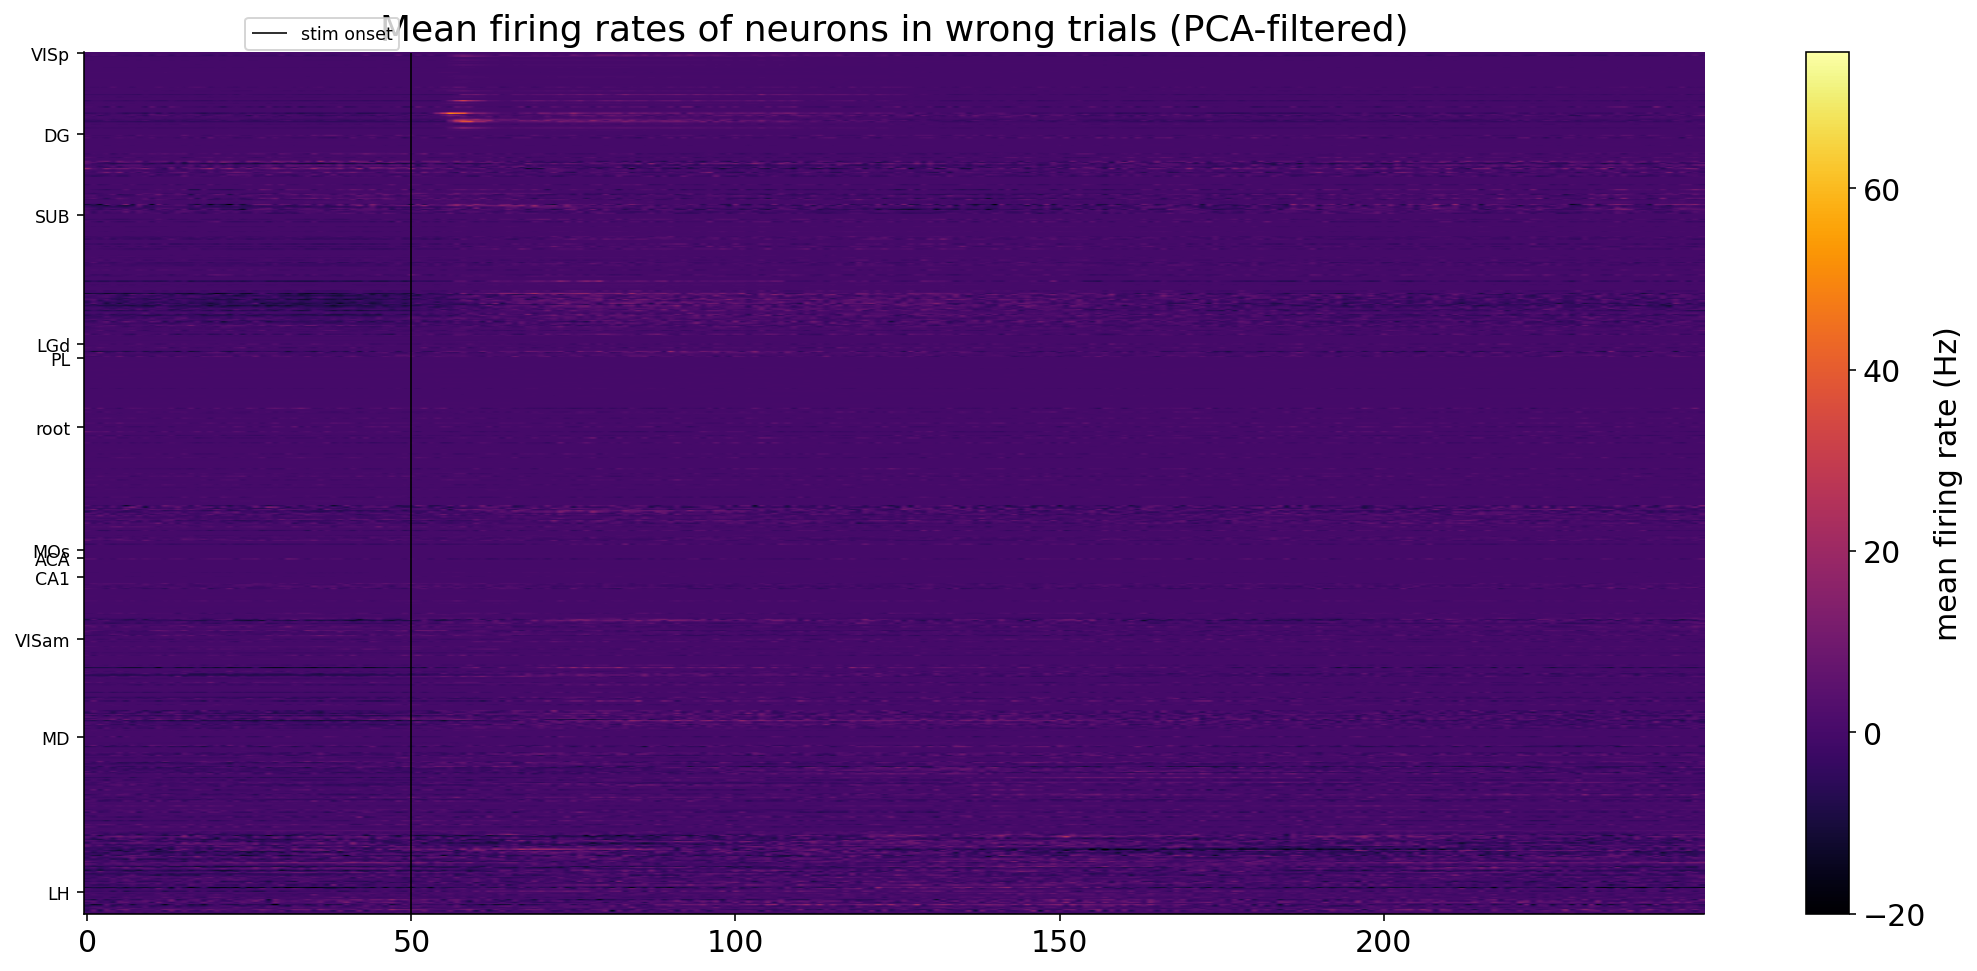

In [ ]:
spks_wrongs = pca_filtered[:, wrongs, :]
plot_firing_rates(spks_wrongs, 'Mean firing rates of neurons in wrong trials (PCA-filtered)')

Min rate: -22.74376165645846
Max rate: 59.080550117583876


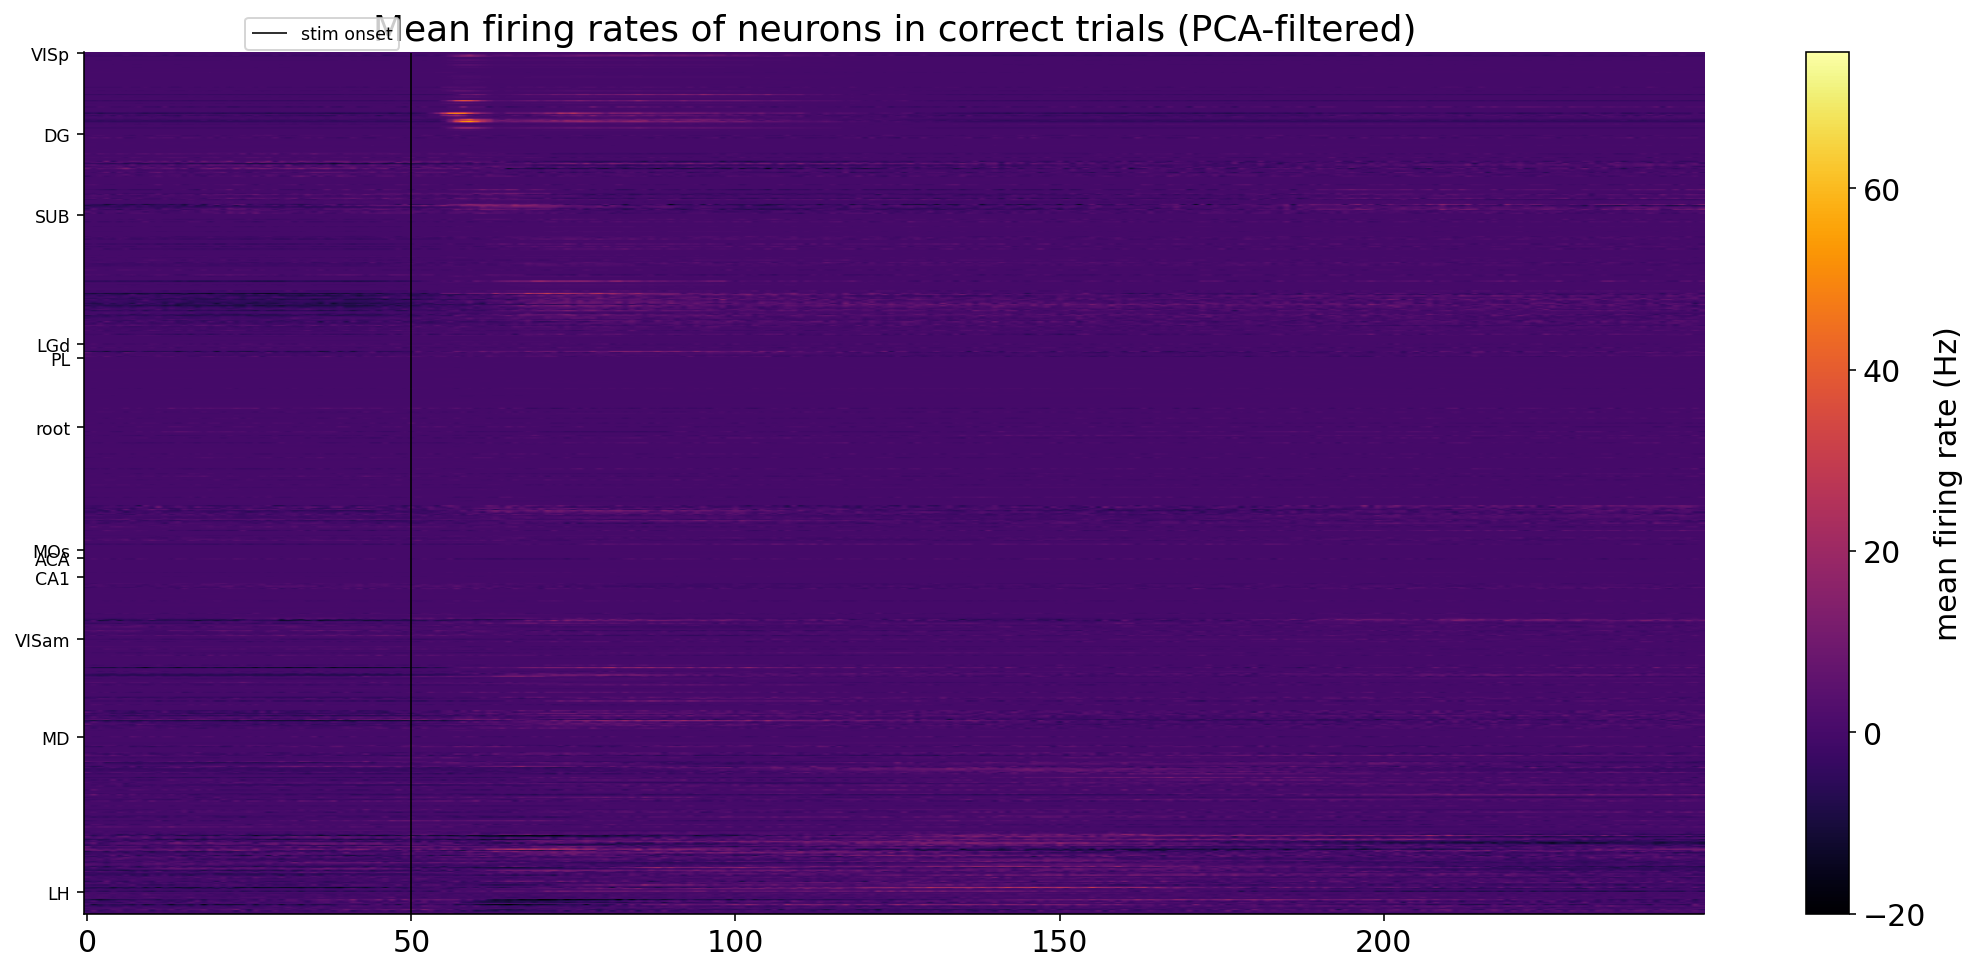

In [ ]:
spks_rights = pca_filtered[:, rights, :]
plot_firing_rates(spks_rights, 'Mean firing rates of neurons in correct trials (PCA-filtered)')

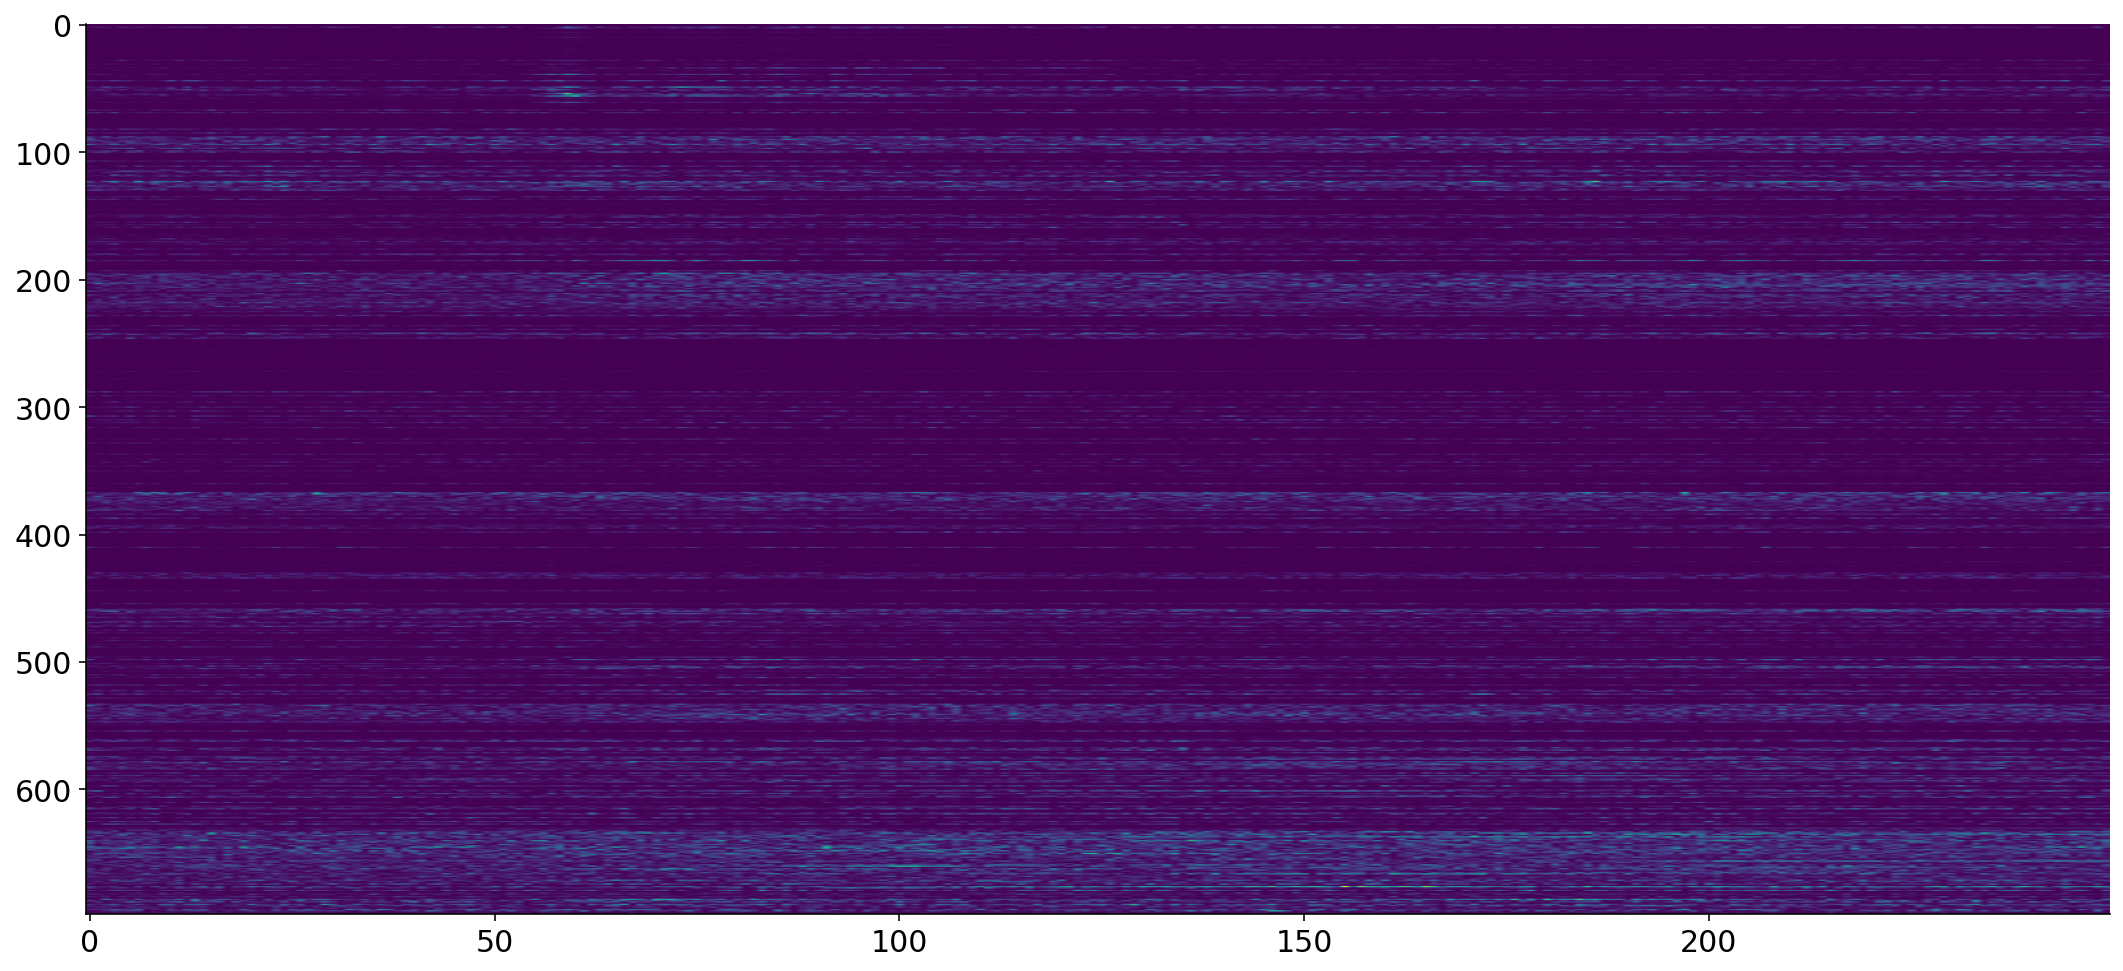

In [ ]:
plt.figure(figsize=(15, 7))
plt.imshow(np.abs(spks_rights.mean(axis=1)-spks_wrongs.mean(axis=1)), 
           aspect='auto')

##4. GPFA